## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [2]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [5]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 384
    tile_size = 384
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 100 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'./{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [8]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [9]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [10]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [11]:
def read_image_mask(fragment_id):
    
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [12]:
# def read_image_mask(fragment_id):
    
#     images = []
    
    
#     # take CFG.in_chans random idxs
#     idxs = np.random.choice(range(65), CFG.in_chans, replace=False)

#     for i in tqdm(idxs):
        
#         img_path = CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif"
#         print(img_path)
        
#         image = cv2.imread(img_path, 0)

#         pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
#         pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

#         image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

#         images.append(image)
#     images = np.stack(images, axis=2)

#     mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
#     mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

#     mask = mask.astype('float32')
#     mask /= 255.0
    
#     return images, mask

In [13]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [14]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [16]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [17]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [18]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [19]:
train_dataset[0][0].shape

torch.Size([6, 384, 384])

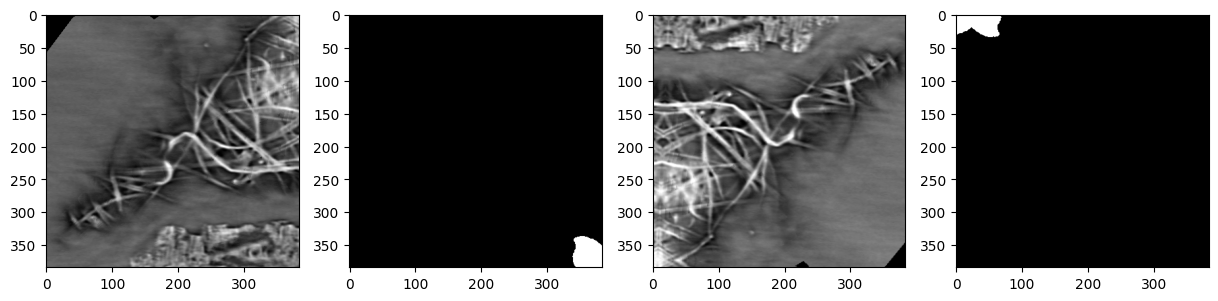

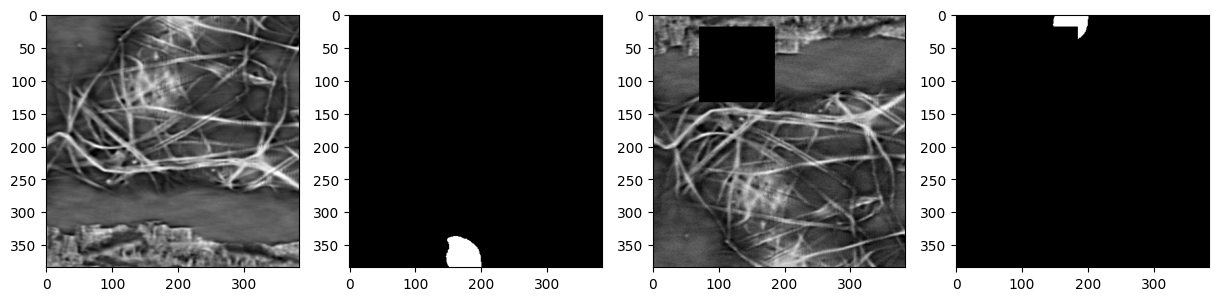

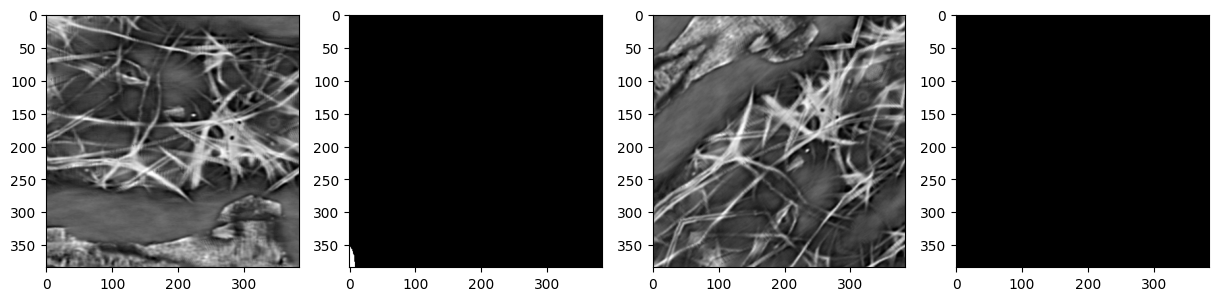

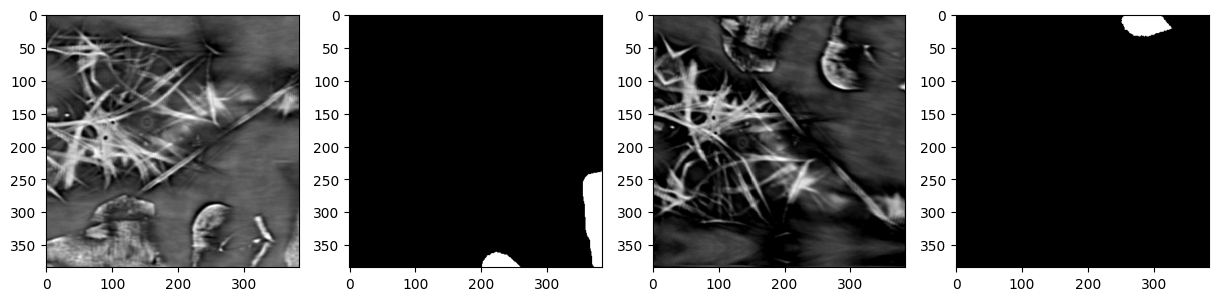

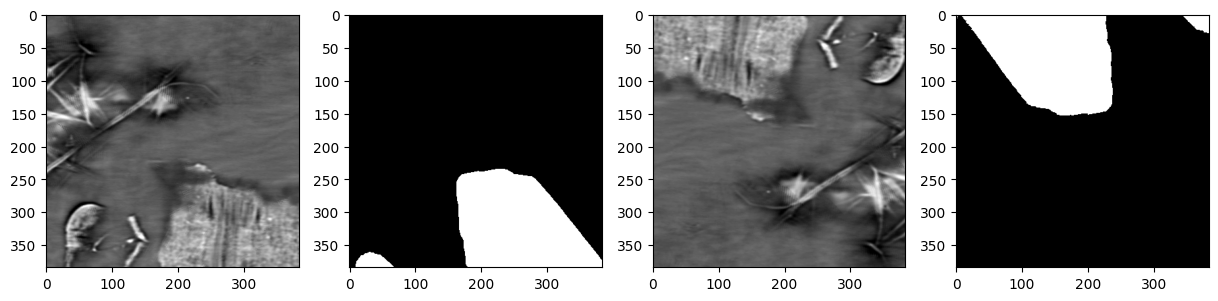

In [20]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [21]:
del plot_dataset
gc.collect()

50889

## model

In [22]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [23]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [24]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b0


## loss

In [25]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    bce_loss =  BCELoss(y_pred, y_true)
    return bce_loss
    
    y_preds_probas = torch.sigmoid(y_pred)
    dxx = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-1) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)
    dyy = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-2) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)

    # Average over all pixels
    kin_energy = torch.mean(dxx + dyy)

    
    return bce_loss + kin_energy
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [26]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [27]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 100+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [28]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [29]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1181610813338347
th: 0.15, fbeta: 0.11816099943067716
th: 0.2, fbeta: 0.11815995505947564
th: 0.25, fbeta: 0.11817021636155398
th: 0.3, fbeta: 0.11844965682312834
th: 0.35, fbeta: 0.11766976476549014
th: 0.4, fbeta: 0.11269373502487479
th: 0.45, fbeta: 0.20774599449591144
th: 0.5, fbeta: 0.21663028605502452
th: 0.55, fbeta: 0.20648567164534878
th: 0.6, fbeta: 0.17429664728364225
th: 0.65, fbeta: 0.11476458086282802
th: 0.7, fbeta: 0.051411742280343904
th: 0.75, fbeta: 0.016917472496494987
th: 0.8, fbeta: 0.004657183773790857
th: 0.85, fbeta: 0.0010049552609157919
th: 0.9, fbeta: 0.0001291510932050839
th: 0.95, fbeta: 9.36174431383015e-07


best_th: 0.5, fbeta: 0.21663028605502452
Epoch 1 - avg_train_loss: 0.7489  avg_val_loss: 0.6367  time: 28s
Epoch 1 - avgScore: 0.2166
Epoch 1 - Save Best Score: 0.2166 Model
Epoch 1 - Save Best Loss: 0.6367 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.11815757296660538
th: 0.15, fbeta: 0.118126202300712
th: 0.2, fbeta: 0.11798163220679994
th: 0.25, fbeta: 0.11809895479013954
th: 0.3, fbeta: 0.2066324422528053
th: 0.35, fbeta: 0.2245940290227207
th: 0.4, fbeta: 0.23324569748846444
th: 0.45, fbeta: 0.23741396983733304
th: 0.5, fbeta: 0.2292343570565923
th: 0.55, fbeta: 0.20169687322533675
th: 0.6, fbeta: 0.1460197238612323
th: 0.65, fbeta: 0.08058032632553531
th: 0.7, fbeta: 0.03768261026869078
th: 0.75, fbeta: 0.016708954413303344
th: 0.8, fbeta: 0.007059401342710384
th: 0.85, fbeta: 0.0025361195457872902
th: 0.9, fbeta: 0.0006134967417998825
th: 0.95, fbeta: 6.362917432278559e-05


best_th: 0.45, fbeta: 0.23741396983733304
Epoch 2 - avg_train_loss: 0.6105  avg_val_loss: 0.4979  time: 26s
Epoch 2 - avgScore: 0.2374
Epoch 2 - Save Best Score: 0.2374 Model
Epoch 2 - Save Best Loss: 0.4979 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.2297008046080226
th: 0.15, fbeta: 0.24611729992806475
th: 0.2, fbeta: 0.26697479757225273
th: 0.25, fbeta: 0.2960058134377099
th: 0.3, fbeta: 0.32994698490416896
th: 0.35, fbeta: 0.36320176044452385
th: 0.4, fbeta: 0.39324030397510956
th: 0.45, fbeta: 0.41806394299748345
th: 0.5, fbeta: 0.43751966334960746
th: 0.55, fbeta: 0.44766943882306265
th: 0.6, fbeta: 0.43638392473009746
th: 0.65, fbeta: 0.3549266054234945
th: 0.7, fbeta: 0.20096444118425452
th: 0.75, fbeta: 0.07397889119410991
th: 0.8, fbeta: 0.010300026384146751
th: 0.85, fbeta: 0.0002106013338682407
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.55, fbeta: 0.44766943882306265
Epoch 3 - avg_train_loss: 0.3443  avg_val_loss: 0.2911  time: 26s
Epoch 3 - avgScore: 0.4477
Epoch 3 - Save Best Score: 0.4477 Model
Epoch 3 - Save Best Loss: 0.2911 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2940443103210322
th: 0.15, fbeta: 0.3375127565779582
th: 0.2, fbeta: 0.37694662662682776
th: 0.25, fbeta: 0.4113737242287747
th: 0.3, fbeta: 0.43867934927526697
th: 0.35, fbeta: 0.4542747638285541
th: 0.4, fbeta: 0.4591807110436606
th: 0.45, fbeta: 0.45310220907941
th: 0.5, fbeta: 0.43598518368494793
th: 0.55, fbeta: 0.3976797648245494
th: 0.6, fbeta: 0.34007465621686517
th: 0.65, fbeta: 0.25756316605406665
th: 0.7, fbeta: 0.1576841466237231
th: 0.75, fbeta: 0.06508319202385503
th: 0.8, fbeta: 0.015086510009670897
th: 0.85, fbeta: 0.0009440979329180025
th: 0.9, fbeta: 0.0
th: 0.95, fbeta: 0.0


best_th: 0.4, fbeta: 0.4591807110436606
Epoch 4 - avg_train_loss: 0.2595  avg_val_loss: 0.2415  time: 26s
Epoch 4 - avgScore: 0.4592
Epoch 4 - Save Best Score: 0.4592 Model
Epoch 4 - Save Best Loss: 0.2415 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31094450571999166
th: 0.15, fbeta: 0.3449526998260355
th: 0.2, fbeta: 0.3793757228132348
th: 0.25, fbeta: 0.40614920871945226
th: 0.3, fbeta: 0.42212733344886816
th: 0.35, fbeta: 0.4264571096132961
th: 0.4, fbeta: 0.4271560003092037
th: 0.45, fbeta: 0.4215791718870761
th: 0.5, fbeta: 0.4105476934921538
th: 0.55, fbeta: 0.3879178492912056
th: 0.6, fbeta: 0.3534964505457909
th: 0.65, fbeta: 0.30336949794767504
th: 0.7, fbeta: 0.23215134451713318
th: 0.75, fbeta: 0.13834093099891098
th: 0.8, fbeta: 0.06233039554592231
th: 0.85, fbeta: 0.016452693587161064
th: 0.9, fbeta: 0.0013535094290820341
th: 0.95, fbeta: 0.0


best_th: 0.4, fbeta: 0.4271560003092037
Epoch 5 - avg_train_loss: 0.2409  avg_val_loss: 0.2550  time: 26s
Epoch 5 - avgScore: 0.4272


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33596347711923474
th: 0.15, fbeta: 0.36433303952218277
th: 0.2, fbeta: 0.3819651953053693
th: 0.25, fbeta: 0.39404054823011847
th: 0.3, fbeta: 0.40246706639861296
th: 0.35, fbeta: 0.4107405888274802
th: 0.4, fbeta: 0.4162513585066122
th: 0.45, fbeta: 0.4209379639043689
th: 0.5, fbeta: 0.42319940606802564
th: 0.55, fbeta: 0.42033645636966566
th: 0.6, fbeta: 0.4060128008823426
th: 0.65, fbeta: 0.3759549081068222
th: 0.7, fbeta: 0.33082309063668197
th: 0.75, fbeta: 0.27287151811754806
th: 0.8, fbeta: 0.19018004868145863
th: 0.85, fbeta: 0.09984999090522578
th: 0.9, fbeta: 0.026606212128702986
th: 0.95, fbeta: 0.0021416260486012855


best_th: 0.5, fbeta: 0.42319940606802564
Epoch 6 - avg_train_loss: 0.2301  avg_val_loss: 0.2554  time: 26s
Epoch 6 - avgScore: 0.4232


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35930023235640435
th: 0.15, fbeta: 0.3915340768630676
th: 0.2, fbeta: 0.4105515329141198
th: 0.25, fbeta: 0.4238274742242954
th: 0.3, fbeta: 0.4357190117921741
th: 0.35, fbeta: 0.442217727485172
th: 0.4, fbeta: 0.44265381275475396
th: 0.45, fbeta: 0.4417044594600317
th: 0.5, fbeta: 0.43829678409283757
th: 0.55, fbeta: 0.4274268595321986
th: 0.6, fbeta: 0.4061292391010059
th: 0.65, fbeta: 0.37873166442752376
th: 0.7, fbeta: 0.3426406521953571
th: 0.75, fbeta: 0.2969403206389265
th: 0.8, fbeta: 0.23998816347387922
th: 0.85, fbeta: 0.16920785109856543
th: 0.9, fbeta: 0.08606452166264034
th: 0.95, fbeta: 0.010086353367103356


best_th: 0.4, fbeta: 0.44265381275475396
Epoch 7 - avg_train_loss: 0.2210  avg_val_loss: 0.2485  time: 26s
Epoch 7 - avgScore: 0.4427


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34221781690411923
th: 0.15, fbeta: 0.384963754851424
th: 0.2, fbeta: 0.41782620956940614
th: 0.25, fbeta: 0.44283886599048544
th: 0.3, fbeta: 0.4623129851026321
th: 0.35, fbeta: 0.47547252655029293
th: 0.4, fbeta: 0.4834027030148823
th: 0.45, fbeta: 0.49143407573324777
th: 0.5, fbeta: 0.4987179514254506
th: 0.55, fbeta: 0.5030789157967844
th: 0.6, fbeta: 0.5006263161792807
th: 0.65, fbeta: 0.48920765366763214
th: 0.7, fbeta: 0.4726545214439593
th: 0.75, fbeta: 0.44121949878054667
th: 0.8, fbeta: 0.3918375252329423
th: 0.85, fbeta: 0.3186810308515488
th: 0.9, fbeta: 0.2164598430541194
th: 0.95, fbeta: 0.0681044167760834


best_th: 0.55, fbeta: 0.5030789157967844
Epoch 8 - avg_train_loss: 0.2142  avg_val_loss: 0.2340  time: 26s
Epoch 8 - avgScore: 0.5031
Epoch 8 - Save Best Score: 0.5031 Model
Epoch 8 - Save Best Loss: 0.2340 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3629860872251177
th: 0.15, fbeta: 0.4022214686748948
th: 0.2, fbeta: 0.4328061510284489
th: 0.25, fbeta: 0.4523682794934119
th: 0.3, fbeta: 0.4671343134397504
th: 0.35, fbeta: 0.4763864967528357
th: 0.4, fbeta: 0.4801257140993026
th: 0.45, fbeta: 0.4805279872737005
th: 0.5, fbeta: 0.4786634547997424
th: 0.55, fbeta: 0.4751066953375879
th: 0.6, fbeta: 0.4646563347434966
th: 0.65, fbeta: 0.4447096948929218
th: 0.7, fbeta: 0.4167355986885974
th: 0.75, fbeta: 0.37679429203934944
th: 0.8, fbeta: 0.3281780682290582
th: 0.85, fbeta: 0.270829537134386
th: 0.9, fbeta: 0.1959333677330604
th: 0.95, fbeta: 0.0769925942124407


best_th: 0.45, fbeta: 0.4805279872737005
Epoch 9 - avg_train_loss: 0.2074  avg_val_loss: 0.2356  time: 26s
Epoch 9 - avgScore: 0.4805


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3735390437336553
th: 0.15, fbeta: 0.3996939476853468
th: 0.2, fbeta: 0.41280559978299136
th: 0.25, fbeta: 0.42363600197092866
th: 0.3, fbeta: 0.4320061041778522
th: 0.35, fbeta: 0.434465053919471
th: 0.4, fbeta: 0.43128952122972203
th: 0.45, fbeta: 0.4260076443518054
th: 0.5, fbeta: 0.41799430569300977
th: 0.55, fbeta: 0.40140395548137847
th: 0.6, fbeta: 0.38066079176659245
th: 0.65, fbeta: 0.3548074981756804
th: 0.7, fbeta: 0.3258024341155053
th: 0.75, fbeta: 0.2928030617095289
th: 0.8, fbeta: 0.2497556532572915
th: 0.85, fbeta: 0.18976912453034242
th: 0.9, fbeta: 0.10920835477520568
th: 0.95, fbeta: 0.025961901299298713


best_th: 0.35, fbeta: 0.434465053919471
Epoch 10 - avg_train_loss: 0.2037  avg_val_loss: 0.2573  time: 26s
Epoch 10 - avgScore: 0.4345


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38309806981475086
th: 0.15, fbeta: 0.4032805125467397
th: 0.2, fbeta: 0.41510646030281956
th: 0.25, fbeta: 0.42274649992556657
th: 0.3, fbeta: 0.43175346247092505
th: 0.35, fbeta: 0.4409687463430221
th: 0.4, fbeta: 0.44407945204437277
th: 0.45, fbeta: 0.44015533211407665
th: 0.5, fbeta: 0.43140675217095104
th: 0.55, fbeta: 0.4177426131935215
th: 0.6, fbeta: 0.3954783359192142
th: 0.65, fbeta: 0.3676821376893089
th: 0.7, fbeta: 0.3314247253609557
th: 0.75, fbeta: 0.2908676164012991
th: 0.8, fbeta: 0.23958817215777214
th: 0.85, fbeta: 0.17004643574114456
th: 0.9, fbeta: 0.08186758491128023
th: 0.95, fbeta: 0.01086896750426024


best_th: 0.4, fbeta: 0.44407945204437277
Epoch 11 - avg_train_loss: 0.1997  avg_val_loss: 0.2742  time: 26s
Epoch 11 - avgScore: 0.4441


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40006783940139967
th: 0.15, fbeta: 0.4265949546257523
th: 0.2, fbeta: 0.443021676647221
th: 0.25, fbeta: 0.45645143886295486
th: 0.3, fbeta: 0.47176231019790843
th: 0.35, fbeta: 0.4801914679887841
th: 0.4, fbeta: 0.48455442167948076
th: 0.45, fbeta: 0.4874054365020685
th: 0.5, fbeta: 0.4854244411051495
th: 0.55, fbeta: 0.4768066927552251
th: 0.6, fbeta: 0.461147114805386
th: 0.65, fbeta: 0.4387511834687268
th: 0.7, fbeta: 0.40783654828139765
th: 0.75, fbeta: 0.36746400070923957
th: 0.8, fbeta: 0.31576687421267313
th: 0.85, fbeta: 0.24463910736920638
th: 0.9, fbeta: 0.14780978824444713
th: 0.95, fbeta: 0.031734005456973045


best_th: 0.45, fbeta: 0.4874054365020685
Epoch 12 - avg_train_loss: 0.1917  avg_val_loss: 0.2581  time: 26s
Epoch 12 - avgScore: 0.4874


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39749983975290243
th: 0.15, fbeta: 0.4333875360006122
th: 0.2, fbeta: 0.46005314450063306
th: 0.25, fbeta: 0.47856058995255796
th: 0.3, fbeta: 0.49290194677353494
th: 0.35, fbeta: 0.500726932632383
th: 0.4, fbeta: 0.5062202982580568
th: 0.45, fbeta: 0.5089544706413792
th: 0.5, fbeta: 0.5079666445151262
th: 0.55, fbeta: 0.5010573713996913
th: 0.6, fbeta: 0.48640197322318296
th: 0.65, fbeta: 0.46179450388807936
th: 0.7, fbeta: 0.42498913687239664
th: 0.75, fbeta: 0.3742107810689089
th: 0.8, fbeta: 0.313434488078834
th: 0.85, fbeta: 0.24286414712906984
th: 0.9, fbeta: 0.15386401495815583
th: 0.95, fbeta: 0.04154206186816256


best_th: 0.45, fbeta: 0.5089544706413792
Epoch 13 - avg_train_loss: 0.1901  avg_val_loss: 0.2532  time: 26s
Epoch 13 - avgScore: 0.5090
Epoch 13 - Save Best Score: 0.5090 Model
Epoch 13 - Save Best Loss: 0.2532 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40623212932632413
th: 0.15, fbeta: 0.435877092608629
th: 0.2, fbeta: 0.45804392931154336
th: 0.25, fbeta: 0.47468034646912344
th: 0.3, fbeta: 0.48568840538800345
th: 0.35, fbeta: 0.49280162330509136
th: 0.4, fbeta: 0.4959520714574129
th: 0.45, fbeta: 0.4988220565366536
th: 0.5, fbeta: 0.49831005371643877
th: 0.55, fbeta: 0.4925057433600604
th: 0.6, fbeta: 0.4797223266490047
th: 0.65, fbeta: 0.46119860783975086
th: 0.7, fbeta: 0.433491666736647
th: 0.75, fbeta: 0.3910016657259473
th: 0.8, fbeta: 0.3354248210959459
th: 0.85, fbeta: 0.2547179855226398
th: 0.9, fbeta: 0.1421992303021523
th: 0.95, fbeta: 0.034413331069350496


best_th: 0.45, fbeta: 0.4988220565366536
Epoch 14 - avg_train_loss: 0.1817  avg_val_loss: 0.2597  time: 26s
Epoch 14 - avgScore: 0.4988


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37530637768513697
th: 0.15, fbeta: 0.40328168034665224
th: 0.2, fbeta: 0.42469275575017557
th: 0.25, fbeta: 0.43998556385080634
th: 0.3, fbeta: 0.4539754075360303
th: 0.35, fbeta: 0.4643375739085461
th: 0.4, fbeta: 0.4741382128530143
th: 0.45, fbeta: 0.481234886972729
th: 0.5, fbeta: 0.4869196971292861
th: 0.55, fbeta: 0.4844395543685012
th: 0.6, fbeta: 0.47714329663833416
th: 0.65, fbeta: 0.4635487738813606
th: 0.7, fbeta: 0.4428722081066968
th: 0.75, fbeta: 0.40991982358493095
th: 0.8, fbeta: 0.36046916349873015
th: 0.85, fbeta: 0.2973467923014476
th: 0.9, fbeta: 0.21459358469541898
th: 0.95, fbeta: 0.09612688835638677


best_th: 0.5, fbeta: 0.4869196971292861
Epoch 15 - avg_train_loss: 0.1778  avg_val_loss: 0.2554  time: 26s
Epoch 15 - avgScore: 0.4869


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38583144475499737
th: 0.15, fbeta: 0.41538812603679387
th: 0.2, fbeta: 0.4380291429567609
th: 0.25, fbeta: 0.45304097438778307
th: 0.3, fbeta: 0.463979867952119
th: 0.35, fbeta: 0.47011337518612545
th: 0.4, fbeta: 0.4745369295343685
th: 0.45, fbeta: 0.47857545452715355
th: 0.5, fbeta: 0.4807264699453267
th: 0.55, fbeta: 0.47822100592278843
th: 0.6, fbeta: 0.4737522335208795
th: 0.65, fbeta: 0.4600216903460661
th: 0.7, fbeta: 0.436775457235547
th: 0.75, fbeta: 0.4048750458750879
th: 0.8, fbeta: 0.36063925730013247
th: 0.85, fbeta: 0.30314324640044504
th: 0.9, fbeta: 0.22245934253206007
th: 0.95, fbeta: 0.10156152053781432


best_th: 0.5, fbeta: 0.4807264699453267
Epoch 16 - avg_train_loss: 0.1734  avg_val_loss: 0.2576  time: 26s
Epoch 16 - avgScore: 0.4807


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42613856727113486
th: 0.15, fbeta: 0.4551979327733864
th: 0.2, fbeta: 0.47301428062900813
th: 0.25, fbeta: 0.4854206764355137
th: 0.3, fbeta: 0.4929616600667069
th: 0.35, fbeta: 0.49558488804246775
th: 0.4, fbeta: 0.4953857439654758
th: 0.45, fbeta: 0.49120218186816533
th: 0.5, fbeta: 0.4814837901662749
th: 0.55, fbeta: 0.4641121799950571
th: 0.6, fbeta: 0.44342138922878543
th: 0.65, fbeta: 0.41882802444116524
th: 0.7, fbeta: 0.38605188833136395
th: 0.75, fbeta: 0.34470860545891735
th: 0.8, fbeta: 0.2937968160939228
th: 0.85, fbeta: 0.2343537202208206
th: 0.9, fbeta: 0.15920133033597444
th: 0.95, fbeta: 0.06639878381222714


best_th: 0.35, fbeta: 0.49558488804246775
Epoch 17 - avg_train_loss: 0.1711  avg_val_loss: 0.2761  time: 26s
Epoch 17 - avgScore: 0.4956


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37161602227075163
th: 0.15, fbeta: 0.3968476637250424
th: 0.2, fbeta: 0.41709539376693305
th: 0.25, fbeta: 0.43402658694957713
th: 0.3, fbeta: 0.4481855992338036
th: 0.35, fbeta: 0.45962279942299794
th: 0.4, fbeta: 0.4680173388634142
th: 0.45, fbeta: 0.4739717167004817
th: 0.5, fbeta: 0.4786339030159044
th: 0.55, fbeta: 0.47906535214371415
th: 0.6, fbeta: 0.47441220278527935
th: 0.65, fbeta: 0.4634655868618739
th: 0.7, fbeta: 0.4443259289394826
th: 0.75, fbeta: 0.4130272007956673
th: 0.8, fbeta: 0.3700236441255859
th: 0.85, fbeta: 0.30725752918995264
th: 0.9, fbeta: 0.2169686029068415
th: 0.95, fbeta: 0.08954190045860765


best_th: 0.55, fbeta: 0.47906535214371415
Epoch 18 - avg_train_loss: 0.1652  avg_val_loss: 0.2565  time: 26s
Epoch 18 - avgScore: 0.4791


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38811247850345404
th: 0.15, fbeta: 0.41524961984779973
th: 0.2, fbeta: 0.4365645513423401
th: 0.25, fbeta: 0.45488861204873443
th: 0.3, fbeta: 0.46952782077910427
th: 0.35, fbeta: 0.4816739865759396
th: 0.4, fbeta: 0.49154697037307055
th: 0.45, fbeta: 0.4988213941019651
th: 0.5, fbeta: 0.5046450864174652
th: 0.55, fbeta: 0.5042270829486811
th: 0.6, fbeta: 0.49753857106924254
th: 0.65, fbeta: 0.48912342900329947
th: 0.7, fbeta: 0.4772390380625312
th: 0.75, fbeta: 0.4621858726278906
th: 0.8, fbeta: 0.43624599385516805
th: 0.85, fbeta: 0.394438908977171
th: 0.9, fbeta: 0.33216201112123966
th: 0.95, fbeta: 0.22420933593288792


best_th: 0.5, fbeta: 0.5046450864174652
Epoch 19 - avg_train_loss: 0.1614  avg_val_loss: 0.2604  time: 26s
Epoch 19 - avgScore: 0.5046


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4294104070793511
th: 0.15, fbeta: 0.4575565482419816
th: 0.2, fbeta: 0.4770039305211242
th: 0.25, fbeta: 0.4881818988990241
th: 0.3, fbeta: 0.494575001671916
th: 0.35, fbeta: 0.4979244658574909
th: 0.4, fbeta: 0.49766044253336345
th: 0.45, fbeta: 0.49456504154503467
th: 0.5, fbeta: 0.48724763745747135
th: 0.55, fbeta: 0.47503171487903967
th: 0.6, fbeta: 0.4594906765853283
th: 0.65, fbeta: 0.44063107792079004
th: 0.7, fbeta: 0.41918564766206534
th: 0.75, fbeta: 0.38425579233253426
th: 0.8, fbeta: 0.3364906049204403
th: 0.85, fbeta: 0.27952813770004903
th: 0.9, fbeta: 0.20669258909527485
th: 0.95, fbeta: 0.099048120145774


best_th: 0.35, fbeta: 0.4979244658574909
Epoch 20 - avg_train_loss: 0.1586  avg_val_loss: 0.2713  time: 26s
Epoch 20 - avgScore: 0.4979


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4047729277362268
th: 0.15, fbeta: 0.42597136976503525
th: 0.2, fbeta: 0.43638707105064733
th: 0.25, fbeta: 0.44149012241433216
th: 0.3, fbeta: 0.43912273152061987
th: 0.35, fbeta: 0.43584735182302126
th: 0.4, fbeta: 0.43004749984250285
th: 0.45, fbeta: 0.4201800475098151
th: 0.5, fbeta: 0.4113691504570211
th: 0.55, fbeta: 0.40010308445291104
th: 0.6, fbeta: 0.38378486561480557
th: 0.65, fbeta: 0.3584009837395079
th: 0.7, fbeta: 0.3292050169338551
th: 0.75, fbeta: 0.29445652616122203
th: 0.8, fbeta: 0.25384487969541525
th: 0.85, fbeta: 0.205358168043825
th: 0.9, fbeta: 0.13870168319970422
th: 0.95, fbeta: 0.05612600153367457


best_th: 0.25, fbeta: 0.44149012241433216
Epoch 21 - avg_train_loss: 0.1541  avg_val_loss: 0.3239  time: 26s
Epoch 21 - avgScore: 0.4415


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4120705416791871
th: 0.15, fbeta: 0.4404084925932419
th: 0.2, fbeta: 0.4633509835635946
th: 0.25, fbeta: 0.4838170853234842
th: 0.3, fbeta: 0.4983433705154385
th: 0.35, fbeta: 0.5053336358859345
th: 0.4, fbeta: 0.508415796062612
th: 0.45, fbeta: 0.5088640159769052
th: 0.5, fbeta: 0.5056817059783127
th: 0.55, fbeta: 0.49982586003683194
th: 0.6, fbeta: 0.49167489477956267
th: 0.65, fbeta: 0.4819353260747144
th: 0.7, fbeta: 0.4646465370080442
th: 0.75, fbeta: 0.43890285807416346
th: 0.8, fbeta: 0.40608790807137585
th: 0.85, fbeta: 0.3632081100760662
th: 0.9, fbeta: 0.3051591752560367
th: 0.95, fbeta: 0.20679205582956323


best_th: 0.45, fbeta: 0.5088640159769052
Epoch 22 - avg_train_loss: 0.1515  avg_val_loss: 0.2711  time: 26s
Epoch 22 - avgScore: 0.5089


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3998921939526679
th: 0.15, fbeta: 0.4279959137035921
th: 0.2, fbeta: 0.451376173375286
th: 0.25, fbeta: 0.4678315742243834
th: 0.3, fbeta: 0.4797349270303738
th: 0.35, fbeta: 0.4896865269533493
th: 0.4, fbeta: 0.4948518822623971
th: 0.45, fbeta: 0.4964057482561729
th: 0.5, fbeta: 0.4959068343800741
th: 0.55, fbeta: 0.4922477144234987
th: 0.6, fbeta: 0.48387516292762467
th: 0.65, fbeta: 0.469986835545176
th: 0.7, fbeta: 0.45121529181416703
th: 0.75, fbeta: 0.42511646176929513
th: 0.8, fbeta: 0.3869803332950708
th: 0.85, fbeta: 0.33052471358480046
th: 0.9, fbeta: 0.2583929638640228
th: 0.95, fbeta: 0.14574775240089932


best_th: 0.45, fbeta: 0.4964057482561729
Epoch 23 - avg_train_loss: 0.1459  avg_val_loss: 0.2616  time: 26s
Epoch 23 - avgScore: 0.4964


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4027839068162169
th: 0.15, fbeta: 0.4243299957616633
th: 0.2, fbeta: 0.43940802181645344
th: 0.25, fbeta: 0.4503306878390968
th: 0.3, fbeta: 0.45787444198775923
th: 0.35, fbeta: 0.46448364965033634
th: 0.4, fbeta: 0.4673358155298299
th: 0.45, fbeta: 0.4674129766549528
th: 0.5, fbeta: 0.46495300246581184
th: 0.55, fbeta: 0.4583244563780644
th: 0.6, fbeta: 0.44742337384711833
th: 0.65, fbeta: 0.4311619769419295
th: 0.7, fbeta: 0.4106685779777624
th: 0.75, fbeta: 0.38421346005845375
th: 0.8, fbeta: 0.3496960528904547
th: 0.85, fbeta: 0.3007212774629944
th: 0.9, fbeta: 0.2349704637764177
th: 0.95, fbeta: 0.1301010703451619


best_th: 0.45, fbeta: 0.4674129766549528
Epoch 24 - avg_train_loss: 0.1435  avg_val_loss: 0.2963  time: 26s
Epoch 24 - avgScore: 0.4674


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39211686713345295
th: 0.15, fbeta: 0.41331682064960346
th: 0.2, fbeta: 0.42914929847849215
th: 0.25, fbeta: 0.44268117096056214
th: 0.3, fbeta: 0.454024064882003
th: 0.35, fbeta: 0.46369110608945735
th: 0.4, fbeta: 0.47262704413316997
th: 0.45, fbeta: 0.48038246516339006
th: 0.5, fbeta: 0.4858099944101588
th: 0.55, fbeta: 0.48986876477751806
th: 0.6, fbeta: 0.4905212247049371
th: 0.65, fbeta: 0.49098483663654546
th: 0.7, fbeta: 0.4880177102687466
th: 0.75, fbeta: 0.4816080092889461
th: 0.8, fbeta: 0.4696463835257101
th: 0.85, fbeta: 0.4516879019285581
th: 0.9, fbeta: 0.42107277314166264
th: 0.95, fbeta: 0.35426770661001283


best_th: 0.65, fbeta: 0.49098483663654546
Epoch 25 - avg_train_loss: 0.1403  avg_val_loss: 0.3012  time: 26s
Epoch 25 - avgScore: 0.4910


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4066057776781242
th: 0.15, fbeta: 0.4308816463067623
th: 0.2, fbeta: 0.4496724720583208
th: 0.25, fbeta: 0.4659101135317395
th: 0.3, fbeta: 0.4767139701274924
th: 0.35, fbeta: 0.48386900383563103
th: 0.4, fbeta: 0.49063294797438506
th: 0.45, fbeta: 0.49562264678118595
th: 0.5, fbeta: 0.4993976125651925
th: 0.55, fbeta: 0.501800247861217
th: 0.6, fbeta: 0.501298508111815
th: 0.65, fbeta: 0.496375646967445
th: 0.7, fbeta: 0.4845629927452874
th: 0.75, fbeta: 0.46921981793072115
th: 0.8, fbeta: 0.4406411764830149
th: 0.85, fbeta: 0.39827114653295154
th: 0.9, fbeta: 0.3316716124319648
th: 0.95, fbeta: 0.21923189204963975


best_th: 0.55, fbeta: 0.501800247861217
Epoch 26 - avg_train_loss: 0.1393  avg_val_loss: 0.2843  time: 26s
Epoch 26 - avgScore: 0.5018


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40413780914684566
th: 0.15, fbeta: 0.4280785195079512
th: 0.2, fbeta: 0.44770610322270854
th: 0.25, fbeta: 0.4636378157794068
th: 0.3, fbeta: 0.4773987955870515
th: 0.35, fbeta: 0.48738503070742095
th: 0.4, fbeta: 0.49462676614966494
th: 0.45, fbeta: 0.49939611228267533
th: 0.5, fbeta: 0.4987438704096966
th: 0.55, fbeta: 0.4938074560767266
th: 0.6, fbeta: 0.48338842514769964
th: 0.65, fbeta: 0.4678217135814398
th: 0.7, fbeta: 0.446171195949055
th: 0.75, fbeta: 0.4162096259146423
th: 0.8, fbeta: 0.3727426293125502
th: 0.85, fbeta: 0.3108204890218987
th: 0.9, fbeta: 0.22218102791611502
th: 0.95, fbeta: 0.08906330003765339


best_th: 0.45, fbeta: 0.49939611228267533
Epoch 27 - avg_train_loss: 0.1345  avg_val_loss: 0.2742  time: 26s
Epoch 27 - avgScore: 0.4994


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.417872652958275
th: 0.15, fbeta: 0.4379586400106135
th: 0.2, fbeta: 0.45380861107615933
th: 0.25, fbeta: 0.462975736869414
th: 0.3, fbeta: 0.46536775851277035
th: 0.35, fbeta: 0.46533630577057256
th: 0.4, fbeta: 0.46444954526439913
th: 0.45, fbeta: 0.45682038956042936
th: 0.5, fbeta: 0.44313229243554036
th: 0.55, fbeta: 0.4239697743146122
th: 0.6, fbeta: 0.3970042788008663
th: 0.65, fbeta: 0.3658766063722872
th: 0.7, fbeta: 0.3327117814058746
th: 0.75, fbeta: 0.2902578669810619
th: 0.8, fbeta: 0.2340512377485379
th: 0.85, fbeta: 0.17254762103129045
th: 0.9, fbeta: 0.10355701132884879
th: 0.95, fbeta: 0.03144431068264208


best_th: 0.3, fbeta: 0.46536775851277035
Epoch 28 - avg_train_loss: 0.1324  avg_val_loss: 0.3127  time: 26s
Epoch 28 - avgScore: 0.4654


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4130306480818754
th: 0.15, fbeta: 0.439060458511824
th: 0.2, fbeta: 0.45728136339582903
th: 0.25, fbeta: 0.4713062892747662
th: 0.3, fbeta: 0.48079379915523623
th: 0.35, fbeta: 0.4860466547868016
th: 0.4, fbeta: 0.4912147709777451
th: 0.45, fbeta: 0.49110868998514534
th: 0.5, fbeta: 0.48388898621091403
th: 0.55, fbeta: 0.47439894168546776
th: 0.6, fbeta: 0.4640423442078481
th: 0.65, fbeta: 0.4492700787034672
th: 0.7, fbeta: 0.427833024007119
th: 0.75, fbeta: 0.39631297944353744
th: 0.8, fbeta: 0.36047532615603584
th: 0.85, fbeta: 0.3152486693617574
th: 0.9, fbeta: 0.2525581722046067
th: 0.95, fbeta: 0.15250000011369258


best_th: 0.4, fbeta: 0.4912147709777451
Epoch 29 - avg_train_loss: 0.1308  avg_val_loss: 0.2935  time: 27s
Epoch 29 - avgScore: 0.4912


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4075827975288149
th: 0.15, fbeta: 0.42974025713233216
th: 0.2, fbeta: 0.448069660370375
th: 0.25, fbeta: 0.4637526492503972
th: 0.3, fbeta: 0.47671314302740175
th: 0.35, fbeta: 0.48782547241676805
th: 0.4, fbeta: 0.4956960764406364
th: 0.45, fbeta: 0.5030716058727682
th: 0.5, fbeta: 0.5059489594849715
th: 0.55, fbeta: 0.5051837901560197
th: 0.6, fbeta: 0.5002471329853717
th: 0.65, fbeta: 0.4928502950883388
th: 0.7, fbeta: 0.4827356395361305
th: 0.75, fbeta: 0.46725459700562005
th: 0.8, fbeta: 0.446141868849946
th: 0.85, fbeta: 0.4141471771136943
th: 0.9, fbeta: 0.3556136583875583
th: 0.95, fbeta: 0.24550136295287714


best_th: 0.5, fbeta: 0.5059489594849715
Epoch 30 - avg_train_loss: 0.1275  avg_val_loss: 0.2976  time: 26s
Epoch 30 - avgScore: 0.5059


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4345225794749654
th: 0.15, fbeta: 0.45312380640543964
th: 0.2, fbeta: 0.46749327191851453
th: 0.25, fbeta: 0.47937383662564176
th: 0.3, fbeta: 0.48663019110718625
th: 0.35, fbeta: 0.49228644571198404
th: 0.4, fbeta: 0.49330999422878835
th: 0.45, fbeta: 0.4931193973144403
th: 0.5, fbeta: 0.4902736995456063
th: 0.55, fbeta: 0.4839735530316588
th: 0.6, fbeta: 0.4747127794847729
th: 0.65, fbeta: 0.4588471555106888
th: 0.7, fbeta: 0.43872176512814376
th: 0.75, fbeta: 0.4140133984615932
th: 0.8, fbeta: 0.38398771078229393
th: 0.85, fbeta: 0.3446913641156093
th: 0.9, fbeta: 0.28944408265819055
th: 0.95, fbeta: 0.18867744101345943


best_th: 0.4, fbeta: 0.49330999422878835
Epoch 31 - avg_train_loss: 0.1219  avg_val_loss: 0.3198  time: 26s
Epoch 31 - avgScore: 0.4933


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4697956555550614
th: 0.15, fbeta: 0.4901351152257657
th: 0.2, fbeta: 0.5059328932617665
th: 0.25, fbeta: 0.5140824371220081
th: 0.3, fbeta: 0.5152610833123719
th: 0.35, fbeta: 0.5112044494743747
th: 0.4, fbeta: 0.5028945609777211
th: 0.45, fbeta: 0.49107345346895787
th: 0.5, fbeta: 0.4759099109048552
th: 0.55, fbeta: 0.4572946328443028
th: 0.6, fbeta: 0.436358045246945
th: 0.65, fbeta: 0.41230867952701156
th: 0.7, fbeta: 0.3847292041603089
th: 0.75, fbeta: 0.35431046031692975
th: 0.8, fbeta: 0.32135291953879724
th: 0.85, fbeta: 0.2787845284000929
th: 0.9, fbeta: 0.2150620789846142
th: 0.95, fbeta: 0.1129191289839172


best_th: 0.3, fbeta: 0.5152610833123719
Epoch 32 - avg_train_loss: 0.1227  avg_val_loss: 0.3276  time: 26s
Epoch 32 - avgScore: 0.5153
Epoch 32 - Save Best Score: 0.5153 Model
Epoch 32 - Save Best Loss: 0.3276 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44782707722635984
th: 0.15, fbeta: 0.46913956807629864
th: 0.2, fbeta: 0.4852371490970327
th: 0.25, fbeta: 0.4970640235925815
th: 0.3, fbeta: 0.502206346916475
th: 0.35, fbeta: 0.5036768619740859
th: 0.4, fbeta: 0.5025300354335113
th: 0.45, fbeta: 0.4961034847966621
th: 0.5, fbeta: 0.48667071398747735
th: 0.55, fbeta: 0.4743995288435318
th: 0.6, fbeta: 0.45972868029597985
th: 0.65, fbeta: 0.44104507440878693
th: 0.7, fbeta: 0.4186420782714198
th: 0.75, fbeta: 0.3914672322090624
th: 0.8, fbeta: 0.35960473439425567
th: 0.85, fbeta: 0.3193100037282026
th: 0.9, fbeta: 0.266754030826119
th: 0.95, fbeta: 0.17406735977950397


best_th: 0.35, fbeta: 0.5036768619740859
Epoch 33 - avg_train_loss: 0.1194  avg_val_loss: 0.3224  time: 26s
Epoch 33 - avgScore: 0.5037


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41282990726288626
th: 0.15, fbeta: 0.4350032130442131
th: 0.2, fbeta: 0.45024963515942024
th: 0.25, fbeta: 0.46322122556317924
th: 0.3, fbeta: 0.47402352201854553
th: 0.35, fbeta: 0.48265623753409836
th: 0.4, fbeta: 0.4877965861219564
th: 0.45, fbeta: 0.4901785576472143
th: 0.5, fbeta: 0.4902174905381238
th: 0.55, fbeta: 0.4870478931106531
th: 0.6, fbeta: 0.48180942893926837
th: 0.65, fbeta: 0.47482723651588465
th: 0.7, fbeta: 0.4651873570844841
th: 0.75, fbeta: 0.44943996870076763
th: 0.8, fbeta: 0.4257556107633098
th: 0.85, fbeta: 0.39361075521702343
th: 0.9, fbeta: 0.3475737605450695
th: 0.95, fbeta: 0.2737082552833526


best_th: 0.5, fbeta: 0.4902174905381238
Epoch 34 - avg_train_loss: 0.1200  avg_val_loss: 0.2962  time: 26s
Epoch 34 - avgScore: 0.4902


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4587709114630501
th: 0.15, fbeta: 0.4796449454674574
th: 0.2, fbeta: 0.4924757231228011
th: 0.25, fbeta: 0.5037499249156148
th: 0.3, fbeta: 0.5104680745002065
th: 0.35, fbeta: 0.5128416470100171
th: 0.4, fbeta: 0.5112781591796607
th: 0.45, fbeta: 0.5066377635005321
th: 0.5, fbeta: 0.5006485878855397
th: 0.55, fbeta: 0.4934778403247421
th: 0.6, fbeta: 0.4831906610171621
th: 0.65, fbeta: 0.4690543849640629
th: 0.7, fbeta: 0.45040962727780737
th: 0.75, fbeta: 0.42648002169576926
th: 0.8, fbeta: 0.39756232134125175
th: 0.85, fbeta: 0.36190858824848054
th: 0.9, fbeta: 0.31636338822401733
th: 0.95, fbeta: 0.24566416528763038


best_th: 0.35, fbeta: 0.5128416470100171
Epoch 35 - avg_train_loss: 0.1164  avg_val_loss: 0.3246  time: 26s
Epoch 35 - avgScore: 0.5128


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4294325429145129
th: 0.15, fbeta: 0.4482801173120743
th: 0.2, fbeta: 0.462705027726287
th: 0.25, fbeta: 0.4717516539349974
th: 0.3, fbeta: 0.4792498038739563
th: 0.35, fbeta: 0.48340891914467593
th: 0.4, fbeta: 0.48615292816637873
th: 0.45, fbeta: 0.4852023872123176
th: 0.5, fbeta: 0.4803855251442418
th: 0.55, fbeta: 0.4711990632909187
th: 0.6, fbeta: 0.4557785230443198
th: 0.65, fbeta: 0.43675387797765836
th: 0.7, fbeta: 0.41741579603780815
th: 0.75, fbeta: 0.3954749364122893
th: 0.8, fbeta: 0.3663135410370759
th: 0.85, fbeta: 0.32349537466689715
th: 0.9, fbeta: 0.26843320165563567
th: 0.95, fbeta: 0.1864551712066765


best_th: 0.4, fbeta: 0.48615292816637873
Epoch 36 - avg_train_loss: 0.1133  avg_val_loss: 0.3165  time: 26s
Epoch 36 - avgScore: 0.4862


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4520561205115925
th: 0.15, fbeta: 0.47065345449424734
th: 0.2, fbeta: 0.47712408292545483
th: 0.25, fbeta: 0.48284706144907474
th: 0.3, fbeta: 0.48737263018689586
th: 0.35, fbeta: 0.486286094951928
th: 0.4, fbeta: 0.4801259069416122
th: 0.45, fbeta: 0.471377412494783
th: 0.5, fbeta: 0.4582966754702935
th: 0.55, fbeta: 0.442335235891525
th: 0.6, fbeta: 0.4224996538133446
th: 0.65, fbeta: 0.3996432772858197
th: 0.7, fbeta: 0.37421042411511757
th: 0.75, fbeta: 0.3425379150467039
th: 0.8, fbeta: 0.3048770482750587
th: 0.85, fbeta: 0.2606874861817232
th: 0.9, fbeta: 0.2025017786478964
th: 0.95, fbeta: 0.12171515895143492


best_th: 0.3, fbeta: 0.48737263018689586
Epoch 37 - avg_train_loss: 0.1116  avg_val_loss: 0.3377  time: 26s
Epoch 37 - avgScore: 0.4874


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4293625175395919
th: 0.15, fbeta: 0.45303623044793134
th: 0.2, fbeta: 0.4696325266135966
th: 0.25, fbeta: 0.48204635652667344
th: 0.3, fbeta: 0.49244344905693394
th: 0.35, fbeta: 0.500333481024934
th: 0.4, fbeta: 0.5042301346228094
th: 0.45, fbeta: 0.5059084227492812
th: 0.5, fbeta: 0.5078271798640018
th: 0.55, fbeta: 0.5078085525708899
th: 0.6, fbeta: 0.5032390629904518
th: 0.65, fbeta: 0.49389760694052265
th: 0.7, fbeta: 0.47960856021923204
th: 0.75, fbeta: 0.4590574603997765
th: 0.8, fbeta: 0.43002142670543037
th: 0.85, fbeta: 0.3888534625863896
th: 0.9, fbeta: 0.3269947105071123
th: 0.95, fbeta: 0.22542038078656937


best_th: 0.5, fbeta: 0.5078271798640018
Epoch 38 - avg_train_loss: 0.1120  avg_val_loss: 0.2978  time: 27s
Epoch 38 - avgScore: 0.5078


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44452136746836773
th: 0.15, fbeta: 0.46429295780083474
th: 0.2, fbeta: 0.47660638076543893
th: 0.25, fbeta: 0.4849512000601814
th: 0.3, fbeta: 0.48764381125683287
th: 0.35, fbeta: 0.4867023637795712
th: 0.4, fbeta: 0.4847889237926557
th: 0.45, fbeta: 0.47963518539377886
th: 0.5, fbeta: 0.4714685329411129
th: 0.55, fbeta: 0.4587990297850419
th: 0.6, fbeta: 0.4410758696776373
th: 0.65, fbeta: 0.4202987450540941
th: 0.7, fbeta: 0.3974081783338849
th: 0.75, fbeta: 0.3723280581935089
th: 0.8, fbeta: 0.3418276985389677
th: 0.85, fbeta: 0.3021731850517882
th: 0.9, fbeta: 0.24838605870471095
th: 0.95, fbeta: 0.16102115212878262


best_th: 0.3, fbeta: 0.48764381125683287
Epoch 39 - avg_train_loss: 0.1090  avg_val_loss: 0.3173  time: 26s
Epoch 39 - avgScore: 0.4876


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.440729852268045
th: 0.15, fbeta: 0.4644244277273722
th: 0.2, fbeta: 0.48362115768998265
th: 0.25, fbeta: 0.49890562985793685
th: 0.3, fbeta: 0.5103524137153292
th: 0.35, fbeta: 0.5170670353272373
th: 0.4, fbeta: 0.5198843781165631
th: 0.45, fbeta: 0.5203556328919304
th: 0.5, fbeta: 0.5177179003630753
th: 0.55, fbeta: 0.5126871438804258
th: 0.6, fbeta: 0.504396314924053
th: 0.65, fbeta: 0.49100501094168375
th: 0.7, fbeta: 0.4753364503068762
th: 0.75, fbeta: 0.4563874651000771
th: 0.8, fbeta: 0.43031266982001243
th: 0.85, fbeta: 0.3895099546631677
th: 0.9, fbeta: 0.33100061826520677
th: 0.95, fbeta: 0.23742543669037697


best_th: 0.45, fbeta: 0.5203556328919304
Epoch 40 - avg_train_loss: 0.1080  avg_val_loss: 0.3215  time: 26s
Epoch 40 - avgScore: 0.5204
Epoch 40 - Save Best Score: 0.5204 Model
Epoch 40 - Save Best Loss: 0.3215 Model


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42336991356295806
th: 0.15, fbeta: 0.4467526500603403
th: 0.2, fbeta: 0.46512253932763137
th: 0.25, fbeta: 0.4776278490363649
th: 0.3, fbeta: 0.4850869105041516
th: 0.35, fbeta: 0.49049548185378117
th: 0.4, fbeta: 0.494657784359991
th: 0.45, fbeta: 0.49310388218085116
th: 0.5, fbeta: 0.48455754977009463
th: 0.55, fbeta: 0.4720877386230532
th: 0.6, fbeta: 0.45850846590297817
th: 0.65, fbeta: 0.44370777387570337
th: 0.7, fbeta: 0.42191399256489814
th: 0.75, fbeta: 0.39472836911801656
th: 0.8, fbeta: 0.36494677438239836
th: 0.85, fbeta: 0.3263211391099366
th: 0.9, fbeta: 0.27509647844029417
th: 0.95, fbeta: 0.1945851544834806


best_th: 0.4, fbeta: 0.494657784359991
Epoch 41 - avg_train_loss: 0.1061  avg_val_loss: 0.3407  time: 26s
Epoch 41 - avgScore: 0.4947


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4289558244168863
th: 0.15, fbeta: 0.45003429120016303
th: 0.2, fbeta: 0.4662300908965166
th: 0.25, fbeta: 0.477183039520266
th: 0.3, fbeta: 0.48608923045930647
th: 0.35, fbeta: 0.4931720863806428
th: 0.4, fbeta: 0.4951789450738418
th: 0.45, fbeta: 0.4947865399507443
th: 0.5, fbeta: 0.4934193364005519
th: 0.55, fbeta: 0.48841806514911895
th: 0.6, fbeta: 0.48038244002446995
th: 0.65, fbeta: 0.4701997177333051
th: 0.7, fbeta: 0.45532000524201705
th: 0.75, fbeta: 0.4357376774752509
th: 0.8, fbeta: 0.40902102263456136
th: 0.85, fbeta: 0.37137353422512576
th: 0.9, fbeta: 0.3163049966870988
th: 0.95, fbeta: 0.22875975152285302


best_th: 0.4, fbeta: 0.4951789450738418
Epoch 42 - avg_train_loss: 0.1041  avg_val_loss: 0.3166  time: 26s
Epoch 42 - avgScore: 0.4952


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43798114690250084
th: 0.15, fbeta: 0.4586836108570939
th: 0.2, fbeta: 0.4756120203999377
th: 0.25, fbeta: 0.4877052192779658
th: 0.3, fbeta: 0.4954844872036056
th: 0.35, fbeta: 0.4998367029346013
th: 0.4, fbeta: 0.5033771110943575
th: 0.45, fbeta: 0.5051299525122929
th: 0.5, fbeta: 0.5048690760100842
th: 0.55, fbeta: 0.5020402285282192
th: 0.6, fbeta: 0.4954919779559593
th: 0.65, fbeta: 0.48693042775351364
th: 0.7, fbeta: 0.4762926958018077
th: 0.75, fbeta: 0.4599363181563189
th: 0.8, fbeta: 0.43466551445528206
th: 0.85, fbeta: 0.3998316412076125
th: 0.9, fbeta: 0.346385224222285
th: 0.95, fbeta: 0.2561469269360651


best_th: 0.45, fbeta: 0.5051299525122929
Epoch 43 - avg_train_loss: 0.1026  avg_val_loss: 0.3275  time: 26s
Epoch 43 - avgScore: 0.5051


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47243916341198244
th: 0.15, fbeta: 0.4848127138440241
th: 0.2, fbeta: 0.490448736381274
th: 0.25, fbeta: 0.49320627026165775
th: 0.3, fbeta: 0.49026526407059473
th: 0.35, fbeta: 0.48451494947395807
th: 0.4, fbeta: 0.4765615917128801
th: 0.45, fbeta: 0.4653346622759573
th: 0.5, fbeta: 0.45266254371916964
th: 0.55, fbeta: 0.4370188319909364
th: 0.6, fbeta: 0.4180584976072033
th: 0.65, fbeta: 0.39707371055322743
th: 0.7, fbeta: 0.3757173992153247
th: 0.75, fbeta: 0.35026766728836684
th: 0.8, fbeta: 0.31901459161955337
th: 0.85, fbeta: 0.28058270917792894
th: 0.9, fbeta: 0.23227251041876554
th: 0.95, fbeta: 0.15649456868264833


best_th: 0.25, fbeta: 0.49320627026165775
Epoch 44 - avg_train_loss: 0.1012  avg_val_loss: 0.3855  time: 26s
Epoch 44 - avgScore: 0.4932


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4445340521503696
th: 0.15, fbeta: 0.4620858147500062
th: 0.2, fbeta: 0.47393493041522183
th: 0.25, fbeta: 0.4809570715835816
th: 0.3, fbeta: 0.4815839779871657
th: 0.35, fbeta: 0.47765423334566665
th: 0.4, fbeta: 0.47192874581850064
th: 0.45, fbeta: 0.4646365159367568
th: 0.5, fbeta: 0.45809999582723787
th: 0.55, fbeta: 0.449198532799975
th: 0.6, fbeta: 0.4380166662963398
th: 0.65, fbeta: 0.4221991238303418
th: 0.7, fbeta: 0.40133569050480905
th: 0.75, fbeta: 0.3759957559745123
th: 0.8, fbeta: 0.3449560190971582
th: 0.85, fbeta: 0.30502249596896225
th: 0.9, fbeta: 0.25353108519759593
th: 0.95, fbeta: 0.18129781526210162


best_th: 0.3, fbeta: 0.4815839779871657
Epoch 45 - avg_train_loss: 0.0997  avg_val_loss: 0.3544  time: 26s
Epoch 45 - avgScore: 0.4816


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4464024565428386
th: 0.15, fbeta: 0.46041045626898747
th: 0.2, fbeta: 0.46791367264138767
th: 0.25, fbeta: 0.4691561093731155
th: 0.3, fbeta: 0.4686067799326801
th: 0.35, fbeta: 0.4657987935775564
th: 0.4, fbeta: 0.4618987511523828
th: 0.45, fbeta: 0.4545610868677442
th: 0.5, fbeta: 0.4455910456502705
th: 0.55, fbeta: 0.4355521800102648
th: 0.6, fbeta: 0.4244118058558887
th: 0.65, fbeta: 0.40861692339357786
th: 0.7, fbeta: 0.38931121260118157
th: 0.75, fbeta: 0.3694310840956749
th: 0.8, fbeta: 0.34571320950089873
th: 0.85, fbeta: 0.31490004728004706
th: 0.9, fbeta: 0.27160331547954725
th: 0.95, fbeta: 0.20633552976127006


best_th: 0.25, fbeta: 0.4691561093731155
Epoch 46 - avg_train_loss: 0.1000  avg_val_loss: 0.4109  time: 26s
Epoch 46 - avgScore: 0.4692


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4393045786369748
th: 0.15, fbeta: 0.46144127848297467
th: 0.2, fbeta: 0.4776676640562767
th: 0.25, fbeta: 0.4877449523700013
th: 0.3, fbeta: 0.4929920145841295
th: 0.35, fbeta: 0.49522833848075803
th: 0.4, fbeta: 0.49643406444435134
th: 0.45, fbeta: 0.49656872655993606
th: 0.5, fbeta: 0.49589566189163037
th: 0.55, fbeta: 0.49245372307431245
th: 0.6, fbeta: 0.4865034718917362
th: 0.65, fbeta: 0.47862814151019
th: 0.7, fbeta: 0.46608082015256624
th: 0.75, fbeta: 0.44783056924761316
th: 0.8, fbeta: 0.42400915874882295
th: 0.85, fbeta: 0.3926414664682636
th: 0.9, fbeta: 0.3505016053040452
th: 0.95, fbeta: 0.276285052019724


best_th: 0.45, fbeta: 0.49656872655993606
Epoch 47 - avg_train_loss: 0.0973  avg_val_loss: 0.3495  time: 26s
Epoch 47 - avgScore: 0.4966


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45968019709407903
th: 0.15, fbeta: 0.46965734039786605
th: 0.2, fbeta: 0.4734378216032374
th: 0.25, fbeta: 0.47413375213500836
th: 0.3, fbeta: 0.47389556865078236
th: 0.35, fbeta: 0.47190334033226305
th: 0.4, fbeta: 0.46895934122089716
th: 0.45, fbeta: 0.46547779587694693
th: 0.5, fbeta: 0.4580157047404056
th: 0.55, fbeta: 0.4459029963224137
th: 0.6, fbeta: 0.4315487122661614
th: 0.65, fbeta: 0.4134077871148662
th: 0.7, fbeta: 0.39399265462622624
th: 0.75, fbeta: 0.3719656982131294
th: 0.8, fbeta: 0.34313638523094436
th: 0.85, fbeta: 0.30668314959023213
th: 0.9, fbeta: 0.2586011714958006
th: 0.95, fbeta: 0.185077417351934


best_th: 0.25, fbeta: 0.47413375213500836
Epoch 48 - avg_train_loss: 0.0974  avg_val_loss: 0.3998  time: 26s
Epoch 48 - avgScore: 0.4741


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46402754650453265
th: 0.15, fbeta: 0.48353787851521907
th: 0.2, fbeta: 0.49837559981198165
th: 0.25, fbeta: 0.5050343226080019
th: 0.3, fbeta: 0.5070861541880303
th: 0.35, fbeta: 0.5057684788845942
th: 0.4, fbeta: 0.5029673483936933
th: 0.45, fbeta: 0.49815710050772066
th: 0.5, fbeta: 0.49120150564182646
th: 0.55, fbeta: 0.48517969106854425
th: 0.6, fbeta: 0.4772042242506492
th: 0.65, fbeta: 0.46603623463013144
th: 0.7, fbeta: 0.45011917489494396
th: 0.75, fbeta: 0.4286092726293013
th: 0.8, fbeta: 0.40176136074786745
th: 0.85, fbeta: 0.36814643029819405
th: 0.9, fbeta: 0.32146296553898507
th: 0.95, fbeta: 0.24568497372391412


best_th: 0.3, fbeta: 0.5070861541880303
Epoch 49 - avg_train_loss: 0.0972  avg_val_loss: 0.3439  time: 26s
Epoch 49 - avgScore: 0.5071


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46598868504203045
th: 0.15, fbeta: 0.4790679518239505
th: 0.2, fbeta: 0.4860057432851626
th: 0.25, fbeta: 0.48955029307900605
th: 0.3, fbeta: 0.49086697191030665
th: 0.35, fbeta: 0.4901498302554263
th: 0.4, fbeta: 0.4884559865759271
th: 0.45, fbeta: 0.48441981937574957
th: 0.5, fbeta: 0.4780419097551074
th: 0.55, fbeta: 0.4693872842097032
th: 0.6, fbeta: 0.4589374317438381
th: 0.65, fbeta: 0.4455847072530913
th: 0.7, fbeta: 0.4275735388288854
th: 0.75, fbeta: 0.4045486863007594
th: 0.8, fbeta: 0.37615614571390543
th: 0.85, fbeta: 0.3413800864954049
th: 0.9, fbeta: 0.2951366039250282
th: 0.95, fbeta: 0.22405277336307067


best_th: 0.3, fbeta: 0.49086697191030665
Epoch 50 - avg_train_loss: 0.0943  avg_val_loss: 0.3845  time: 26s
Epoch 50 - avgScore: 0.4909


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4626404084166844
th: 0.15, fbeta: 0.47096764098992777
th: 0.2, fbeta: 0.4731899577805757
th: 0.25, fbeta: 0.47307402354907435
th: 0.3, fbeta: 0.46924785108577655
th: 0.35, fbeta: 0.4647930500153687
th: 0.4, fbeta: 0.4551322260460418
th: 0.45, fbeta: 0.44555530719113
th: 0.5, fbeta: 0.43471289226895293
th: 0.55, fbeta: 0.42173650887487785
th: 0.6, fbeta: 0.4048438776156268
th: 0.65, fbeta: 0.38572552736094545
th: 0.7, fbeta: 0.36572472051575067
th: 0.75, fbeta: 0.3418079086346148
th: 0.8, fbeta: 0.31283902592933255
th: 0.85, fbeta: 0.2756623122212083
th: 0.9, fbeta: 0.22819276524307935
th: 0.95, fbeta: 0.157958591704467


best_th: 0.2, fbeta: 0.4731899577805757
Epoch 51 - avg_train_loss: 0.0927  avg_val_loss: 0.3862  time: 26s
Epoch 51 - avgScore: 0.4732


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46105968386551294
th: 0.15, fbeta: 0.47764365864266956
th: 0.2, fbeta: 0.4875449495750148
th: 0.25, fbeta: 0.49023613641553804
th: 0.3, fbeta: 0.49047116327736223
th: 0.35, fbeta: 0.48880852933731006
th: 0.4, fbeta: 0.48611062105961683
th: 0.45, fbeta: 0.4826066944036301
th: 0.5, fbeta: 0.47434416971885723
th: 0.55, fbeta: 0.46482367955849757
th: 0.6, fbeta: 0.4536436121981853
th: 0.65, fbeta: 0.4391145885899039
th: 0.7, fbeta: 0.42385920602021765
th: 0.75, fbeta: 0.406127001779981
th: 0.8, fbeta: 0.3786770345201537
th: 0.85, fbeta: 0.3443102794929175
th: 0.9, fbeta: 0.2984335186546194
th: 0.95, fbeta: 0.22777464965110097


best_th: 0.3, fbeta: 0.49047116327736223
Epoch 52 - avg_train_loss: 0.0908  avg_val_loss: 0.3839  time: 26s
Epoch 52 - avgScore: 0.4905


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4496853146446418
th: 0.15, fbeta: 0.46702793886655225
th: 0.2, fbeta: 0.4782092352365559
th: 0.25, fbeta: 0.48688849102049425
th: 0.3, fbeta: 0.4932645219175037
th: 0.35, fbeta: 0.4964842666844034
th: 0.4, fbeta: 0.4972954063691878
th: 0.45, fbeta: 0.4934544096631292
th: 0.5, fbeta: 0.4864476557337038
th: 0.55, fbeta: 0.4786959891193834
th: 0.6, fbeta: 0.4688241653495462
th: 0.65, fbeta: 0.4561302355975278
th: 0.7, fbeta: 0.44038215728513275
th: 0.75, fbeta: 0.41952748930798484
th: 0.8, fbeta: 0.3951375098124976
th: 0.85, fbeta: 0.3618731362554809
th: 0.9, fbeta: 0.31249759268810406
th: 0.95, fbeta: 0.22851173517273599


best_th: 0.4, fbeta: 0.4972954063691878
Epoch 53 - avg_train_loss: 0.0915  avg_val_loss: 0.3417  time: 26s
Epoch 53 - avgScore: 0.4973


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4264642317593744
th: 0.15, fbeta: 0.4450873275418768
th: 0.2, fbeta: 0.4571668071734893
th: 0.25, fbeta: 0.4655492821631543
th: 0.3, fbeta: 0.47135324421856306
th: 0.35, fbeta: 0.4741934235421228
th: 0.4, fbeta: 0.4755124527287727
th: 0.45, fbeta: 0.4743896177293779
th: 0.5, fbeta: 0.47072224637073146
th: 0.55, fbeta: 0.46644942513663207
th: 0.6, fbeta: 0.4612187310289161
th: 0.65, fbeta: 0.45349012744389844
th: 0.7, fbeta: 0.44451723380391023
th: 0.75, fbeta: 0.4292843696237494
th: 0.8, fbeta: 0.40706960710834594
th: 0.85, fbeta: 0.3757454639676459
th: 0.9, fbeta: 0.32753218066143347
th: 0.95, fbeta: 0.24744781577898245


best_th: 0.4, fbeta: 0.4755124527287727
Epoch 54 - avg_train_loss: 0.0909  avg_val_loss: 0.3561  time: 26s
Epoch 54 - avgScore: 0.4755


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44743946923919264
th: 0.15, fbeta: 0.46221682114301393
th: 0.2, fbeta: 0.4689537288379298
th: 0.25, fbeta: 0.47420041684383113
th: 0.3, fbeta: 0.47538579977302603
th: 0.35, fbeta: 0.4750501538961077
th: 0.4, fbeta: 0.47221150804877576
th: 0.45, fbeta: 0.46664783303751683
th: 0.5, fbeta: 0.4598283479620644
th: 0.55, fbeta: 0.45137944019126935
th: 0.6, fbeta: 0.44138681250678463
th: 0.65, fbeta: 0.42782008120374787
th: 0.7, fbeta: 0.4102225488364983
th: 0.75, fbeta: 0.388069854380259
th: 0.8, fbeta: 0.3645399224591496
th: 0.85, fbeta: 0.33540112053757193
th: 0.9, fbeta: 0.29595694946421075
th: 0.95, fbeta: 0.22907606264447095


best_th: 0.3, fbeta: 0.47538579977302603
Epoch 55 - avg_train_loss: 0.0895  avg_val_loss: 0.4073  time: 26s
Epoch 55 - avgScore: 0.4754


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47268774146183884
th: 0.15, fbeta: 0.4774838810680294
th: 0.2, fbeta: 0.4783490461225502
th: 0.25, fbeta: 0.47595369463522663
th: 0.3, fbeta: 0.4725821421692326
th: 0.35, fbeta: 0.4668704539872402
th: 0.4, fbeta: 0.4595339648355003
th: 0.45, fbeta: 0.44826775408012964
th: 0.5, fbeta: 0.43377290932630946
th: 0.55, fbeta: 0.4202667272848385
th: 0.6, fbeta: 0.40479169566763046
th: 0.65, fbeta: 0.38713529937364033
th: 0.7, fbeta: 0.36384159345999995
th: 0.75, fbeta: 0.3381361234549214
th: 0.8, fbeta: 0.30826542452504685
th: 0.85, fbeta: 0.27530834604730625
th: 0.9, fbeta: 0.2332924412322948
th: 0.95, fbeta: 0.16353992852052873


best_th: 0.2, fbeta: 0.4783490461225502
Epoch 56 - avg_train_loss: 0.0878  avg_val_loss: 0.4319  time: 26s
Epoch 56 - avgScore: 0.4783


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45119981703694834
th: 0.15, fbeta: 0.4630280087979172
th: 0.2, fbeta: 0.46799436094178914
th: 0.25, fbeta: 0.46996577519077637
th: 0.3, fbeta: 0.4707658741483035
th: 0.35, fbeta: 0.46919314394095885
th: 0.4, fbeta: 0.4637664989381125
th: 0.45, fbeta: 0.45649752451525477
th: 0.5, fbeta: 0.44759672101604026
th: 0.55, fbeta: 0.434651003992801
th: 0.6, fbeta: 0.4195036609993503
th: 0.65, fbeta: 0.400862904255808
th: 0.7, fbeta: 0.378629809297122
th: 0.75, fbeta: 0.354175113611438
th: 0.8, fbeta: 0.3258804455135373
th: 0.85, fbeta: 0.29180409893981296
th: 0.9, fbeta: 0.24749215013928294
th: 0.95, fbeta: 0.17623051243901608


best_th: 0.3, fbeta: 0.4707658741483035
Epoch 57 - avg_train_loss: 0.0877  avg_val_loss: 0.3887  time: 26s
Epoch 57 - avgScore: 0.4708


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4474849167304759
th: 0.15, fbeta: 0.4639003283979192
th: 0.2, fbeta: 0.4729761322230478
th: 0.25, fbeta: 0.47815609756685584
th: 0.3, fbeta: 0.4794886787449808
th: 0.35, fbeta: 0.4788690929031966
th: 0.4, fbeta: 0.47687637882879536
th: 0.45, fbeta: 0.4739566278774682
th: 0.5, fbeta: 0.46535368500864427
th: 0.55, fbeta: 0.45568604259458034
th: 0.6, fbeta: 0.4447473239410759
th: 0.65, fbeta: 0.43000585184647844
th: 0.7, fbeta: 0.41288112479446665
th: 0.75, fbeta: 0.38995961568295234
th: 0.8, fbeta: 0.36468193531959237
th: 0.85, fbeta: 0.3300813317552164
th: 0.9, fbeta: 0.2894154032011913
th: 0.95, fbeta: 0.22262070155095504


best_th: 0.3, fbeta: 0.4794886787449808
Epoch 58 - avg_train_loss: 0.0865  avg_val_loss: 0.3946  time: 26s
Epoch 58 - avgScore: 0.4795


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4462057506891179
th: 0.15, fbeta: 0.4582995317398425
th: 0.2, fbeta: 0.46621627435148244
th: 0.25, fbeta: 0.47244581394981316
th: 0.3, fbeta: 0.4758071155612414
th: 0.35, fbeta: 0.47728674674992755
th: 0.4, fbeta: 0.4775193805122242
th: 0.45, fbeta: 0.47418080788405237
th: 0.5, fbeta: 0.46668548205694793
th: 0.55, fbeta: 0.45805868744161193
th: 0.6, fbeta: 0.4466799375870185
th: 0.65, fbeta: 0.43238767493285996
th: 0.7, fbeta: 0.41551994931072356
th: 0.75, fbeta: 0.39586751172272183
th: 0.8, fbeta: 0.37334154704585837
th: 0.85, fbeta: 0.3430493471345927
th: 0.9, fbeta: 0.3032092377140048
th: 0.95, fbeta: 0.2404289143573467


best_th: 0.4, fbeta: 0.4775193805122242
Epoch 59 - avg_train_loss: 0.0851  avg_val_loss: 0.3816  time: 26s
Epoch 59 - avgScore: 0.4775


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4457741979325106
th: 0.15, fbeta: 0.4576268252735907
th: 0.2, fbeta: 0.46533366004474785
th: 0.25, fbeta: 0.4727122232906469
th: 0.3, fbeta: 0.47777809080973793
th: 0.35, fbeta: 0.48076559273623404
th: 0.4, fbeta: 0.48052855156623303
th: 0.45, fbeta: 0.47793084026711335
th: 0.5, fbeta: 0.47460418944887306
th: 0.55, fbeta: 0.46920503336799363
th: 0.6, fbeta: 0.4610959816052531
th: 0.65, fbeta: 0.45045112203207804
th: 0.7, fbeta: 0.4360004778724344
th: 0.75, fbeta: 0.4183370670450733
th: 0.8, fbeta: 0.3984152598804159
th: 0.85, fbeta: 0.37166385957727516
th: 0.9, fbeta: 0.3291181592881238
th: 0.95, fbeta: 0.2587845312451902


best_th: 0.35, fbeta: 0.48076559273623404
Epoch 60 - avg_train_loss: 0.0855  avg_val_loss: 0.3980  time: 26s
Epoch 60 - avgScore: 0.4808


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4429846700103261
th: 0.15, fbeta: 0.45481880177642625
th: 0.2, fbeta: 0.4603272272077053
th: 0.25, fbeta: 0.4629960431456613
th: 0.3, fbeta: 0.46096159164485867
th: 0.35, fbeta: 0.4549650405688042
th: 0.4, fbeta: 0.44734317705794424
th: 0.45, fbeta: 0.436755980976004
th: 0.5, fbeta: 0.42509897524117357
th: 0.55, fbeta: 0.41085377208980034
th: 0.6, fbeta: 0.3954165622915814
th: 0.65, fbeta: 0.37818807110013264
th: 0.7, fbeta: 0.35536316542293744
th: 0.75, fbeta: 0.3305373664283202
th: 0.8, fbeta: 0.30133287640451817
th: 0.85, fbeta: 0.2666439375966679
th: 0.9, fbeta: 0.22150631580220892
th: 0.95, fbeta: 0.15134973569618312


best_th: 0.25, fbeta: 0.4629960431456613
Epoch 61 - avg_train_loss: 0.0885  avg_val_loss: 0.3935  time: 26s
Epoch 61 - avgScore: 0.4630


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4574616208202388
th: 0.15, fbeta: 0.4688119745832284
th: 0.2, fbeta: 0.4749852385554131
th: 0.25, fbeta: 0.4782472637991058
th: 0.3, fbeta: 0.4808072322894057
th: 0.35, fbeta: 0.48106015140536157
th: 0.4, fbeta: 0.4783539324938608
th: 0.45, fbeta: 0.47422755761671187
th: 0.5, fbeta: 0.4657852316378507
th: 0.55, fbeta: 0.45475292522285593
th: 0.6, fbeta: 0.44173368434453114
th: 0.65, fbeta: 0.4259538806265676
th: 0.7, fbeta: 0.4078269448773998
th: 0.75, fbeta: 0.38718838666308536
th: 0.8, fbeta: 0.3639837715537106
th: 0.85, fbeta: 0.3315740903344561
th: 0.9, fbeta: 0.2880087814753838
th: 0.95, fbeta: 0.21879261028209654


best_th: 0.35, fbeta: 0.48106015140536157
Epoch 62 - avg_train_loss: 0.0840  avg_val_loss: 0.4271  time: 26s
Epoch 62 - avgScore: 0.4811


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4541612430112415
th: 0.15, fbeta: 0.46934847191512324
th: 0.2, fbeta: 0.47510710022257113
th: 0.25, fbeta: 0.47768523196496543
th: 0.3, fbeta: 0.47952462992844797
th: 0.35, fbeta: 0.47981634745941837
th: 0.4, fbeta: 0.47877910432122744
th: 0.45, fbeta: 0.4759091622477802
th: 0.5, fbeta: 0.46907056831127736
th: 0.55, fbeta: 0.45950948320511525
th: 0.6, fbeta: 0.4492436301054551
th: 0.65, fbeta: 0.43728490353004545
th: 0.7, fbeta: 0.42176565085921214
th: 0.75, fbeta: 0.4028452615174699
th: 0.8, fbeta: 0.3808715308525585
th: 0.85, fbeta: 0.34898347931165646
th: 0.9, fbeta: 0.3047044099352601
th: 0.95, fbeta: 0.23694394724507786


best_th: 0.35, fbeta: 0.47981634745941837
Epoch 63 - avg_train_loss: 0.0841  avg_val_loss: 0.4133  time: 26s
Epoch 63 - avgScore: 0.4798


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.464498660386816
th: 0.15, fbeta: 0.47862289294903543
th: 0.2, fbeta: 0.48625822511064193
th: 0.25, fbeta: 0.49108802752468206
th: 0.3, fbeta: 0.4911783363050746
th: 0.35, fbeta: 0.48863942430092683
th: 0.4, fbeta: 0.48578361125302305
th: 0.45, fbeta: 0.48246049785169143
th: 0.5, fbeta: 0.47799526796458414
th: 0.55, fbeta: 0.46938796161292307
th: 0.6, fbeta: 0.45786883190019106
th: 0.65, fbeta: 0.44538201038796066
th: 0.7, fbeta: 0.42856689670014597
th: 0.75, fbeta: 0.41028740211591236
th: 0.8, fbeta: 0.38536721248350136
th: 0.85, fbeta: 0.3528957832003144
th: 0.9, fbeta: 0.308404517520456
th: 0.95, fbeta: 0.2359316107343459


best_th: 0.3, fbeta: 0.4911783363050746
Epoch 64 - avg_train_loss: 0.0830  avg_val_loss: 0.4013  time: 26s
Epoch 64 - avgScore: 0.4912


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4388376387856136
th: 0.15, fbeta: 0.456471990086207
th: 0.2, fbeta: 0.46572408589280084
th: 0.25, fbeta: 0.4715842854513941
th: 0.3, fbeta: 0.4768945124682311
th: 0.35, fbeta: 0.4821453276720021
th: 0.4, fbeta: 0.482987685074155
th: 0.45, fbeta: 0.4795928337890792
th: 0.5, fbeta: 0.4736360834528981
th: 0.55, fbeta: 0.46613858526061247
th: 0.6, fbeta: 0.4577118021329688
th: 0.65, fbeta: 0.44911428558825006
th: 0.7, fbeta: 0.43635013144950036
th: 0.75, fbeta: 0.42042956449969077
th: 0.8, fbeta: 0.4002977493486613
th: 0.85, fbeta: 0.3705858730173657
th: 0.9, fbeta: 0.3249881482140571
th: 0.95, fbeta: 0.2513408461479086


best_th: 0.4, fbeta: 0.482987685074155
Epoch 65 - avg_train_loss: 0.0817  avg_val_loss: 0.3746  time: 26s
Epoch 65 - avgScore: 0.4830


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44511620699432536
th: 0.15, fbeta: 0.46282034322535653
th: 0.2, fbeta: 0.47485326805314937
th: 0.25, fbeta: 0.4837278885131884
th: 0.3, fbeta: 0.4880341886620772
th: 0.35, fbeta: 0.48995186162883975
th: 0.4, fbeta: 0.491880612373781
th: 0.45, fbeta: 0.4916647306100763
th: 0.5, fbeta: 0.4882139689850663
th: 0.55, fbeta: 0.48285652104097926
th: 0.6, fbeta: 0.477192635728727
th: 0.65, fbeta: 0.4700973154575891
th: 0.7, fbeta: 0.4593403090967102
th: 0.75, fbeta: 0.4430815225263972
th: 0.8, fbeta: 0.4233594747586745
th: 0.85, fbeta: 0.39385036739242923
th: 0.9, fbeta: 0.3509068045949863
th: 0.95, fbeta: 0.27721292450590895


best_th: 0.4, fbeta: 0.491880612373781
Epoch 66 - avg_train_loss: 0.0813  avg_val_loss: 0.3749  time: 26s
Epoch 66 - avgScore: 0.4919


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4649511637439225
th: 0.15, fbeta: 0.47541529416445544
th: 0.2, fbeta: 0.4798518728295239
th: 0.25, fbeta: 0.4808532508426522
th: 0.3, fbeta: 0.4801385974071302
th: 0.35, fbeta: 0.4775220298203322
th: 0.4, fbeta: 0.4731894898784675
th: 0.45, fbeta: 0.4680948056183383
th: 0.5, fbeta: 0.46028682472294596
th: 0.55, fbeta: 0.44901423722155603
th: 0.6, fbeta: 0.43557887334425477
th: 0.65, fbeta: 0.41943665073736397
th: 0.7, fbeta: 0.40053742988721286
th: 0.75, fbeta: 0.3794189161281445
th: 0.8, fbeta: 0.351861036290641
th: 0.85, fbeta: 0.31715880225325643
th: 0.9, fbeta: 0.2743794613611145
th: 0.95, fbeta: 0.20590501519865795


best_th: 0.25, fbeta: 0.4808532508426522
Epoch 67 - avg_train_loss: 0.0805  avg_val_loss: 0.4320  time: 26s
Epoch 67 - avgScore: 0.4809


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44410555169512717
th: 0.15, fbeta: 0.45814686356744955
th: 0.2, fbeta: 0.4678552472522541
th: 0.25, fbeta: 0.4734103305171161
th: 0.3, fbeta: 0.4757407323777035
th: 0.35, fbeta: 0.47545766386946775
th: 0.4, fbeta: 0.47153114625994635
th: 0.45, fbeta: 0.465920862413302
th: 0.5, fbeta: 0.4565189035360611
th: 0.55, fbeta: 0.4454334199962304
th: 0.6, fbeta: 0.4315478989692787
th: 0.65, fbeta: 0.41615683878714865
th: 0.7, fbeta: 0.3976464677356797
th: 0.75, fbeta: 0.3758788692855637
th: 0.8, fbeta: 0.34611450709630315
th: 0.85, fbeta: 0.3084431292534485
th: 0.9, fbeta: 0.2626682850066313
th: 0.95, fbeta: 0.19059651348581302


best_th: 0.3, fbeta: 0.4757407323777035
Epoch 68 - avg_train_loss: 0.0803  avg_val_loss: 0.4199  time: 26s
Epoch 68 - avgScore: 0.4757


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4472827837707606
th: 0.15, fbeta: 0.45421401637920883
th: 0.2, fbeta: 0.4578857652718748
th: 0.25, fbeta: 0.46058530149910065
th: 0.3, fbeta: 0.46023258849897425
th: 0.35, fbeta: 0.45832093499674664
th: 0.4, fbeta: 0.45330740082836546
th: 0.45, fbeta: 0.4461088489413575
th: 0.5, fbeta: 0.4378211716927102
th: 0.55, fbeta: 0.4272868838061121
th: 0.6, fbeta: 0.41429388705540066
th: 0.65, fbeta: 0.39974297968199496
th: 0.7, fbeta: 0.3824945684112519
th: 0.75, fbeta: 0.3635853069695684
th: 0.8, fbeta: 0.3403274656027606
th: 0.85, fbeta: 0.30878003753395616
th: 0.9, fbeta: 0.26842546087501096
th: 0.95, fbeta: 0.20478885739763972


best_th: 0.25, fbeta: 0.46058530149910065
Epoch 69 - avg_train_loss: 0.0789  avg_val_loss: 0.4447  time: 26s
Epoch 69 - avgScore: 0.4606


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43450815436017365
th: 0.15, fbeta: 0.44708423510274425
th: 0.2, fbeta: 0.45468865522544416
th: 0.25, fbeta: 0.4587044086070578
th: 0.3, fbeta: 0.4604405818650442
th: 0.35, fbeta: 0.46137906356076386
th: 0.4, fbeta: 0.46045700444694826
th: 0.45, fbeta: 0.4548619457156861
th: 0.5, fbeta: 0.44536699855044626
th: 0.55, fbeta: 0.43632209478095507
th: 0.6, fbeta: 0.4251375536660901
th: 0.65, fbeta: 0.4106601449189477
th: 0.7, fbeta: 0.39307411736951936
th: 0.75, fbeta: 0.37105375906354504
th: 0.8, fbeta: 0.34511057442580245
th: 0.85, fbeta: 0.3102477005145036
th: 0.9, fbeta: 0.2674835598353892
th: 0.95, fbeta: 0.1941392945002211


best_th: 0.35, fbeta: 0.46137906356076386
Epoch 70 - avg_train_loss: 0.0798  avg_val_loss: 0.4052  time: 26s
Epoch 70 - avgScore: 0.4614


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46096376153154295
th: 0.15, fbeta: 0.47352727495825264
th: 0.2, fbeta: 0.4767829560411687
th: 0.25, fbeta: 0.47976314543290555
th: 0.3, fbeta: 0.47913437100482176
th: 0.35, fbeta: 0.4753326716037768
th: 0.4, fbeta: 0.46973204964295184
th: 0.45, fbeta: 0.4621338758620083
th: 0.5, fbeta: 0.45304321323877306
th: 0.55, fbeta: 0.44312192589644356
th: 0.6, fbeta: 0.4316606230712527
th: 0.65, fbeta: 0.41726617936335436
th: 0.7, fbeta: 0.40016993368345966
th: 0.75, fbeta: 0.3794624020621892
th: 0.8, fbeta: 0.3519582130620387
th: 0.85, fbeta: 0.3179513099281884
th: 0.9, fbeta: 0.27521893690887334
th: 0.95, fbeta: 0.2082342803001102


best_th: 0.25, fbeta: 0.47976314543290555
Epoch 71 - avg_train_loss: 0.0789  avg_val_loss: 0.4387  time: 26s
Epoch 71 - avgScore: 0.4798


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.467062100497996
th: 0.15, fbeta: 0.48103882385401336
th: 0.2, fbeta: 0.48646781368098957
th: 0.25, fbeta: 0.4871183834335453
th: 0.3, fbeta: 0.48561107232686646
th: 0.35, fbeta: 0.48156345943009093
th: 0.4, fbeta: 0.4758628485219927
th: 0.45, fbeta: 0.4665682328215064
th: 0.5, fbeta: 0.45435394713512883
th: 0.55, fbeta: 0.44451288833607233
th: 0.6, fbeta: 0.4336015793450044
th: 0.65, fbeta: 0.4204208586665342
th: 0.7, fbeta: 0.4021924683213736
th: 0.75, fbeta: 0.37917329185122534
th: 0.8, fbeta: 0.350425725562108
th: 0.85, fbeta: 0.31327589755624013
th: 0.9, fbeta: 0.26885523459393396
th: 0.95, fbeta: 0.20014468990384637


best_th: 0.25, fbeta: 0.4871183834335453
Epoch 72 - avg_train_loss: 0.0771  avg_val_loss: 0.4175  time: 26s
Epoch 72 - avgScore: 0.4871


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44768128577370614
th: 0.15, fbeta: 0.46319608136833246
th: 0.2, fbeta: 0.4735482785315859
th: 0.25, fbeta: 0.4806042818057265
th: 0.3, fbeta: 0.48371553624754016
th: 0.35, fbeta: 0.4840193503090324
th: 0.4, fbeta: 0.4814973779984612
th: 0.45, fbeta: 0.47691945912237876
th: 0.5, fbeta: 0.47043580197597795
th: 0.55, fbeta: 0.46204703094699706
th: 0.6, fbeta: 0.4507773923762725
th: 0.65, fbeta: 0.43898065249757523
th: 0.7, fbeta: 0.42599454128176467
th: 0.75, fbeta: 0.40780306188307186
th: 0.8, fbeta: 0.3848634073568994
th: 0.85, fbeta: 0.3511889747623278
th: 0.9, fbeta: 0.30619023079420316
th: 0.95, fbeta: 0.23620987957361653


best_th: 0.35, fbeta: 0.4840193503090324
Epoch 73 - avg_train_loss: 0.0766  avg_val_loss: 0.4165  time: 26s
Epoch 73 - avgScore: 0.4840


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4455708899562306
th: 0.15, fbeta: 0.45504432712827975
th: 0.2, fbeta: 0.46019624632652006
th: 0.25, fbeta: 0.4659784784151381
th: 0.3, fbeta: 0.4693993647311774
th: 0.35, fbeta: 0.4691219671261274
th: 0.4, fbeta: 0.46655405824920526
th: 0.45, fbeta: 0.4613859771020736
th: 0.5, fbeta: 0.4523666189339166
th: 0.55, fbeta: 0.4422451707018131
th: 0.6, fbeta: 0.4309692604257314
th: 0.65, fbeta: 0.41925291694278594
th: 0.7, fbeta: 0.40381500345845833
th: 0.75, fbeta: 0.38388869705081596
th: 0.8, fbeta: 0.35996590854445387
th: 0.85, fbeta: 0.32804300213762855
th: 0.9, fbeta: 0.28945043958208866
th: 0.95, fbeta: 0.22492491139893916


best_th: 0.3, fbeta: 0.4693993647311774
Epoch 74 - avg_train_loss: 0.0772  avg_val_loss: 0.4329  time: 26s
Epoch 74 - avgScore: 0.4694


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4455528569061819
th: 0.15, fbeta: 0.45491355766393266
th: 0.2, fbeta: 0.4602405345247977
th: 0.25, fbeta: 0.4646575862239805
th: 0.3, fbeta: 0.46675245560614526
th: 0.35, fbeta: 0.46471540514162746
th: 0.4, fbeta: 0.4593732023913739
th: 0.45, fbeta: 0.4521198781853514
th: 0.5, fbeta: 0.440414890489683
th: 0.55, fbeta: 0.4299370606747393
th: 0.6, fbeta: 0.4185714423720125
th: 0.65, fbeta: 0.40382952633136837
th: 0.7, fbeta: 0.3860539423037061
th: 0.75, fbeta: 0.36551404635341217
th: 0.8, fbeta: 0.34093782652768595
th: 0.85, fbeta: 0.3089731008798948
th: 0.9, fbeta: 0.26571793549243117
th: 0.95, fbeta: 0.19684056015396065


best_th: 0.3, fbeta: 0.46675245560614526
Epoch 75 - avg_train_loss: 0.0759  avg_val_loss: 0.4568  time: 26s
Epoch 75 - avgScore: 0.4668


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45205745811752396
th: 0.15, fbeta: 0.4641989413269737
th: 0.2, fbeta: 0.4693442485147444
th: 0.25, fbeta: 0.4725944960671687
th: 0.3, fbeta: 0.4717049180603486
th: 0.35, fbeta: 0.4687726292701583
th: 0.4, fbeta: 0.46446396940061707
th: 0.45, fbeta: 0.45855708175185916
th: 0.5, fbeta: 0.4501241222252082
th: 0.55, fbeta: 0.4396600456724633
th: 0.6, fbeta: 0.4293163022043421
th: 0.65, fbeta: 0.41756657249580525
th: 0.7, fbeta: 0.40147507803246635
th: 0.75, fbeta: 0.382692911615334
th: 0.8, fbeta: 0.359985043538095
th: 0.85, fbeta: 0.3296916788063146
th: 0.9, fbeta: 0.2911374782238762
th: 0.95, fbeta: 0.23013820833173482


best_th: 0.25, fbeta: 0.4725944960671687
Epoch 76 - avg_train_loss: 0.0765  avg_val_loss: 0.4368  time: 26s
Epoch 76 - avgScore: 0.4726


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45531978047514016
th: 0.15, fbeta: 0.4696455865710858
th: 0.2, fbeta: 0.4784027471197071
th: 0.25, fbeta: 0.4826250232397949
th: 0.3, fbeta: 0.48276764326351146
th: 0.35, fbeta: 0.4807765015441231
th: 0.4, fbeta: 0.47852300466922937
th: 0.45, fbeta: 0.47361941572683935
th: 0.5, fbeta: 0.4640698943811636
th: 0.55, fbeta: 0.4536764371714828
th: 0.6, fbeta: 0.4433553408828363
th: 0.65, fbeta: 0.4320672790601997
th: 0.7, fbeta: 0.41722613321307417
th: 0.75, fbeta: 0.39772333465769544
th: 0.8, fbeta: 0.3734380593961817
th: 0.85, fbeta: 0.33950788198066145
th: 0.9, fbeta: 0.292557899134853
th: 0.95, fbeta: 0.22235426130600858


best_th: 0.3, fbeta: 0.48276764326351146
Epoch 77 - avg_train_loss: 0.0746  avg_val_loss: 0.4225  time: 26s
Epoch 77 - avgScore: 0.4828


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4581746735408387
th: 0.15, fbeta: 0.4701953421580257
th: 0.2, fbeta: 0.4791229581337409
th: 0.25, fbeta: 0.4834172953370689
th: 0.3, fbeta: 0.48350384502613214
th: 0.35, fbeta: 0.4819606690703708
th: 0.4, fbeta: 0.47982608760635137
th: 0.45, fbeta: 0.47498691104612933
th: 0.5, fbeta: 0.46667942901095333
th: 0.55, fbeta: 0.45638067644982083
th: 0.6, fbeta: 0.444983000153499
th: 0.65, fbeta: 0.4325877918280463
th: 0.7, fbeta: 0.4176861065232157
th: 0.75, fbeta: 0.39981998866683904
th: 0.8, fbeta: 0.37789205251826047
th: 0.85, fbeta: 0.3458141032828546
th: 0.9, fbeta: 0.30296582491316215
th: 0.95, fbeta: 0.2359837064684176


best_th: 0.3, fbeta: 0.48350384502613214
Epoch 78 - avg_train_loss: 0.0762  avg_val_loss: 0.4242  time: 26s
Epoch 78 - avgScore: 0.4835


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4620422014600864
th: 0.15, fbeta: 0.47737766761149936
th: 0.2, fbeta: 0.4858409276433576
th: 0.25, fbeta: 0.4895476799025211
th: 0.3, fbeta: 0.4890221817296494
th: 0.35, fbeta: 0.48747366287805066
th: 0.4, fbeta: 0.48523629341958974
th: 0.45, fbeta: 0.4813903247936237
th: 0.5, fbeta: 0.47397765109659573
th: 0.55, fbeta: 0.464187254757208
th: 0.6, fbeta: 0.45455627150326805
th: 0.65, fbeta: 0.4425100698291328
th: 0.7, fbeta: 0.427935317568597
th: 0.75, fbeta: 0.41139023642933986
th: 0.8, fbeta: 0.39225405685701187
th: 0.85, fbeta: 0.3636286239770081
th: 0.9, fbeta: 0.3230510973543301
th: 0.95, fbeta: 0.2574247112381483


best_th: 0.25, fbeta: 0.4895476799025211
Epoch 79 - avg_train_loss: 0.0741  avg_val_loss: 0.4329  time: 26s
Epoch 79 - avgScore: 0.4895


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4600994108624655
th: 0.15, fbeta: 0.4749474009587735
th: 0.2, fbeta: 0.48251349464885923
th: 0.25, fbeta: 0.48724995077830224
th: 0.3, fbeta: 0.4878860139959994
th: 0.35, fbeta: 0.4859704864798738
th: 0.4, fbeta: 0.48303100040815855
th: 0.45, fbeta: 0.4776692381782838
th: 0.5, fbeta: 0.46889175759968005
th: 0.55, fbeta: 0.45877898385560395
th: 0.6, fbeta: 0.4466873848646933
th: 0.65, fbeta: 0.43415515182005143
th: 0.7, fbeta: 0.41858928068460843
th: 0.75, fbeta: 0.40031668104161094
th: 0.8, fbeta: 0.37850135638847837
th: 0.85, fbeta: 0.3465693533827474
th: 0.9, fbeta: 0.3023290813157901
th: 0.95, fbeta: 0.23337735133846021


best_th: 0.3, fbeta: 0.4878860139959994
Epoch 80 - avg_train_loss: 0.0755  avg_val_loss: 0.4242  time: 26s
Epoch 80 - avgScore: 0.4879


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4496699452636573
th: 0.15, fbeta: 0.46531357758039865
th: 0.2, fbeta: 0.47566718672344505
th: 0.25, fbeta: 0.48150527126882564
th: 0.3, fbeta: 0.48417989155160124
th: 0.35, fbeta: 0.48524813962179975
th: 0.4, fbeta: 0.485057795639808
th: 0.45, fbeta: 0.48198104363256405
th: 0.5, fbeta: 0.4768448737710503
th: 0.55, fbeta: 0.4695280986083185
th: 0.6, fbeta: 0.4605757008934201
th: 0.65, fbeta: 0.4487099216011501
th: 0.7, fbeta: 0.4349233061056183
th: 0.75, fbeta: 0.41858468210575944
th: 0.8, fbeta: 0.39951989479372135
th: 0.85, fbeta: 0.3725429762738803
th: 0.9, fbeta: 0.3301772111619324
th: 0.95, fbeta: 0.26349393145449


best_th: 0.35, fbeta: 0.48524813962179975
Epoch 81 - avg_train_loss: 0.0754  avg_val_loss: 0.4121  time: 26s
Epoch 81 - avgScore: 0.4852


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45038000829006225
th: 0.15, fbeta: 0.46507675776818197
th: 0.2, fbeta: 0.4736703844013732
th: 0.25, fbeta: 0.4813119896978378
th: 0.3, fbeta: 0.48531525912687246
th: 0.35, fbeta: 0.4859778161730853
th: 0.4, fbeta: 0.48426587823687195
th: 0.45, fbeta: 0.4814534618464897
th: 0.5, fbeta: 0.47596751592895736
th: 0.55, fbeta: 0.4692874398906455
th: 0.6, fbeta: 0.4581021265121003
th: 0.65, fbeta: 0.44577503930489126
th: 0.7, fbeta: 0.4314051809688272
th: 0.75, fbeta: 0.41469347013736807
th: 0.8, fbeta: 0.3947451965127758
th: 0.85, fbeta: 0.36693527533523207
th: 0.9, fbeta: 0.3229750142425537
th: 0.95, fbeta: 0.251813392772162


best_th: 0.35, fbeta: 0.4859778161730853
Epoch 82 - avg_train_loss: 0.0745  avg_val_loss: 0.4223  time: 26s
Epoch 82 - avgScore: 0.4860


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44863656122473405
th: 0.15, fbeta: 0.4630357301033674
th: 0.2, fbeta: 0.4715014098361507
th: 0.25, fbeta: 0.4786013817197369
th: 0.3, fbeta: 0.4814078974422666
th: 0.35, fbeta: 0.4819017129557194
th: 0.4, fbeta: 0.4795764780140732
th: 0.45, fbeta: 0.47533590598164216
th: 0.5, fbeta: 0.46823903971527736
th: 0.55, fbeta: 0.45878844891268844
th: 0.6, fbeta: 0.4472906557835258
th: 0.65, fbeta: 0.43384466423953993
th: 0.7, fbeta: 0.4197963169753854
th: 0.75, fbeta: 0.4021588239941059
th: 0.8, fbeta: 0.3814068661405371
th: 0.85, fbeta: 0.34912223721944097
th: 0.9, fbeta: 0.3055921669971273
th: 0.95, fbeta: 0.23604547018602864


best_th: 0.35, fbeta: 0.4819017129557194
Epoch 83 - avg_train_loss: 0.0753  avg_val_loss: 0.4269  time: 26s
Epoch 83 - avgScore: 0.4819


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45942719087782047
th: 0.15, fbeta: 0.47144171793948736
th: 0.2, fbeta: 0.47906063303998503
th: 0.25, fbeta: 0.4820320700726192
th: 0.3, fbeta: 0.4807832023348944
th: 0.35, fbeta: 0.47717373716100103
th: 0.4, fbeta: 0.4724187674929849
th: 0.45, fbeta: 0.46623921907388627
th: 0.5, fbeta: 0.4553968539294306
th: 0.55, fbeta: 0.4433107383252511
th: 0.6, fbeta: 0.4303739738473102
th: 0.65, fbeta: 0.4149151904197558
th: 0.7, fbeta: 0.39693702307810924
th: 0.75, fbeta: 0.3753257742499481
th: 0.8, fbeta: 0.3495542322504087
th: 0.85, fbeta: 0.317920578614928
th: 0.9, fbeta: 0.27607928049154945
th: 0.95, fbeta: 0.2123852772745855


best_th: 0.25, fbeta: 0.4820320700726192
Epoch 84 - avg_train_loss: 0.0744  avg_val_loss: 0.4431  time: 26s
Epoch 84 - avgScore: 0.4820


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45493369360549457
th: 0.15, fbeta: 0.4702765243161196
th: 0.2, fbeta: 0.4799659612123813
th: 0.25, fbeta: 0.4848330975265084
th: 0.3, fbeta: 0.4874987834195249
th: 0.35, fbeta: 0.4885602072604384
th: 0.4, fbeta: 0.4865872225453472
th: 0.45, fbeta: 0.4833054230061836
th: 0.5, fbeta: 0.4784483266741638
th: 0.55, fbeta: 0.47130671443754496
th: 0.6, fbeta: 0.4621714174209052
th: 0.65, fbeta: 0.45079106001755775
th: 0.7, fbeta: 0.43627902432811727
th: 0.75, fbeta: 0.41766474445210633
th: 0.8, fbeta: 0.39660222811543244
th: 0.85, fbeta: 0.3677523585445971
th: 0.9, fbeta: 0.32525576979248777
th: 0.95, fbeta: 0.2608773916967264


best_th: 0.35, fbeta: 0.4885602072604384
Epoch 85 - avg_train_loss: 0.0732  avg_val_loss: 0.4207  time: 26s
Epoch 85 - avgScore: 0.4886


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45679905897285406
th: 0.15, fbeta: 0.47078403044594697
th: 0.2, fbeta: 0.48009166786582513
th: 0.25, fbeta: 0.4849422261169843
th: 0.3, fbeta: 0.4868331491679082
th: 0.35, fbeta: 0.48733174871785023
th: 0.4, fbeta: 0.48447039116055424
th: 0.45, fbeta: 0.48097377703651556
th: 0.5, fbeta: 0.474624895380938
th: 0.55, fbeta: 0.4657232151842798
th: 0.6, fbeta: 0.45446913542707873
th: 0.65, fbeta: 0.44157678048428006
th: 0.7, fbeta: 0.4266360246101369
th: 0.75, fbeta: 0.4066992311012849
th: 0.8, fbeta: 0.3857098048074188
th: 0.85, fbeta: 0.3548127465252855
th: 0.9, fbeta: 0.31182235382092244
th: 0.95, fbeta: 0.24564059286738404


best_th: 0.35, fbeta: 0.48733174871785023
Epoch 86 - avg_train_loss: 0.0739  avg_val_loss: 0.4309  time: 26s
Epoch 86 - avgScore: 0.4873


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45401063189617535
th: 0.15, fbeta: 0.46921574974209956
th: 0.2, fbeta: 0.47856584569886845
th: 0.25, fbeta: 0.4852775094820597
th: 0.3, fbeta: 0.488992202230782
th: 0.35, fbeta: 0.4895923289088659
th: 0.4, fbeta: 0.486451277890302
th: 0.45, fbeta: 0.4811481457648094
th: 0.5, fbeta: 0.4749986276883252
th: 0.55, fbeta: 0.46660036372592517
th: 0.6, fbeta: 0.45503074091793394
th: 0.65, fbeta: 0.4419124711715513
th: 0.7, fbeta: 0.4266032139875589
th: 0.75, fbeta: 0.40581916466030116
th: 0.8, fbeta: 0.38511228208655846
th: 0.85, fbeta: 0.3562890692677016
th: 0.9, fbeta: 0.3136181857117268
th: 0.95, fbeta: 0.24874049986819977


best_th: 0.35, fbeta: 0.4895923289088659
Epoch 87 - avg_train_loss: 0.0734  avg_val_loss: 0.4285  time: 26s
Epoch 87 - avgScore: 0.4896


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45983507370034377
th: 0.15, fbeta: 0.4750425625143714
th: 0.2, fbeta: 0.4849029607681664
th: 0.25, fbeta: 0.4894014701282216
th: 0.3, fbeta: 0.4915217899574207
th: 0.35, fbeta: 0.4904009384354729
th: 0.4, fbeta: 0.4859622069119819
th: 0.45, fbeta: 0.481648809814403
th: 0.5, fbeta: 0.4749375954326314
th: 0.55, fbeta: 0.4647165264933758
th: 0.6, fbeta: 0.4534183248572156
th: 0.65, fbeta: 0.4405200848070618
th: 0.7, fbeta: 0.42588624820991916
th: 0.75, fbeta: 0.40637062367846033
th: 0.8, fbeta: 0.38522078028710216
th: 0.85, fbeta: 0.35509268321916093
th: 0.9, fbeta: 0.3116330748917223
th: 0.95, fbeta: 0.2459262990320779


best_th: 0.3, fbeta: 0.4915217899574207
Epoch 88 - avg_train_loss: 0.0741  avg_val_loss: 0.4341  time: 26s
Epoch 88 - avgScore: 0.4915


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45681517955631734
th: 0.15, fbeta: 0.47059786929929376
th: 0.2, fbeta: 0.4792740629686012
th: 0.25, fbeta: 0.4825757454898461
th: 0.3, fbeta: 0.4841181742720515
th: 0.35, fbeta: 0.4826261332353083
th: 0.4, fbeta: 0.47906612569030205
th: 0.45, fbeta: 0.47479507851555347
th: 0.5, fbeta: 0.4682005829427855
th: 0.55, fbeta: 0.45871684694223397
th: 0.6, fbeta: 0.44727403133978794
th: 0.65, fbeta: 0.43447061320936586
th: 0.7, fbeta: 0.41942597533049086
th: 0.75, fbeta: 0.40084998609958034
th: 0.8, fbeta: 0.38002663265456543
th: 0.85, fbeta: 0.3514055599398119
th: 0.9, fbeta: 0.30959684875873605
th: 0.95, fbeta: 0.2468307557248033


best_th: 0.3, fbeta: 0.4841181742720515
Epoch 89 - avg_train_loss: 0.0732  avg_val_loss: 0.4356  time: 26s
Epoch 89 - avgScore: 0.4841


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4509255915393058
th: 0.15, fbeta: 0.46508830487238817
th: 0.2, fbeta: 0.47420290709783597
th: 0.25, fbeta: 0.4798425456677416
th: 0.3, fbeta: 0.4826173993194709
th: 0.35, fbeta: 0.48269134448762224
th: 0.4, fbeta: 0.4805601522122618
th: 0.45, fbeta: 0.47722806711055216
th: 0.5, fbeta: 0.47075188201118445
th: 0.55, fbeta: 0.46210366276386317
th: 0.6, fbeta: 0.4515486279209016
th: 0.65, fbeta: 0.4396676126267648
th: 0.7, fbeta: 0.42615028155937373
th: 0.75, fbeta: 0.4090719708408581
th: 0.8, fbeta: 0.3894391237118841
th: 0.85, fbeta: 0.3600022249306171
th: 0.9, fbeta: 0.31744055487475137
th: 0.95, fbeta: 0.25194588260601075


best_th: 0.35, fbeta: 0.48269134448762224
Epoch 90 - avg_train_loss: 0.0737  avg_val_loss: 0.4324  time: 26s
Epoch 90 - avgScore: 0.4827


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4562228120895153
th: 0.15, fbeta: 0.4703878930993174
th: 0.2, fbeta: 0.47832895205266845
th: 0.25, fbeta: 0.48267192388433355
th: 0.3, fbeta: 0.48369263505232957
th: 0.35, fbeta: 0.4814989270345269
th: 0.4, fbeta: 0.4785503996338599
th: 0.45, fbeta: 0.4740589365529453
th: 0.5, fbeta: 0.46736483701073084
th: 0.55, fbeta: 0.45766357939933
th: 0.6, fbeta: 0.44559521273625136
th: 0.65, fbeta: 0.432477947714651
th: 0.7, fbeta: 0.4173436835690388
th: 0.75, fbeta: 0.3984254057953481
th: 0.8, fbeta: 0.37701662918034584
th: 0.85, fbeta: 0.3455346913979944
th: 0.9, fbeta: 0.303495705309734
th: 0.95, fbeta: 0.23941260647088053


best_th: 0.3, fbeta: 0.48369263505232957
Epoch 91 - avg_train_loss: 0.0720  avg_val_loss: 0.4401  time: 26s
Epoch 91 - avgScore: 0.4837


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4653605933559763
th: 0.15, fbeta: 0.47771557261856296
th: 0.2, fbeta: 0.48371438713912557
th: 0.25, fbeta: 0.4869108337599328
th: 0.3, fbeta: 0.4860274199681506
th: 0.35, fbeta: 0.4825660150892336
th: 0.4, fbeta: 0.4781266909024175
th: 0.45, fbeta: 0.4724481601594649
th: 0.5, fbeta: 0.4629770498918573
th: 0.55, fbeta: 0.45144335687148346
th: 0.6, fbeta: 0.4384684840607737
th: 0.65, fbeta: 0.4238835510376421
th: 0.7, fbeta: 0.4061122809983576
th: 0.75, fbeta: 0.3868313567934409
th: 0.8, fbeta: 0.3623989603263448
th: 0.85, fbeta: 0.3292995433301784
th: 0.9, fbeta: 0.2876366597259895
th: 0.95, fbeta: 0.22314921858414752


best_th: 0.25, fbeta: 0.4869108337599328
Epoch 92 - avg_train_loss: 0.0735  avg_val_loss: 0.4508  time: 26s
Epoch 92 - avgScore: 0.4869


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45415877920194936
th: 0.15, fbeta: 0.4683235185989494
th: 0.2, fbeta: 0.4770640054600356
th: 0.25, fbeta: 0.4816784680075459
th: 0.3, fbeta: 0.4840781782784876
th: 0.35, fbeta: 0.4847099282803277
th: 0.4, fbeta: 0.482547949564767
th: 0.45, fbeta: 0.47858620833880083
th: 0.5, fbeta: 0.473225628174715
th: 0.55, fbeta: 0.46576338412472784
th: 0.6, fbeta: 0.4549284537504309
th: 0.65, fbeta: 0.4421471522920152
th: 0.7, fbeta: 0.42747781529627804
th: 0.75, fbeta: 0.4091455689376601
th: 0.8, fbeta: 0.38889776140663646
th: 0.85, fbeta: 0.36002927494503756
th: 0.9, fbeta: 0.3176976116185925
th: 0.95, fbeta: 0.2538836604586862


best_th: 0.35, fbeta: 0.4847099282803277
Epoch 93 - avg_train_loss: 0.0745  avg_val_loss: 0.4317  time: 26s
Epoch 93 - avgScore: 0.4847


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45538145931962265
th: 0.15, fbeta: 0.4695531426002958
th: 0.2, fbeta: 0.4775045891291924
th: 0.25, fbeta: 0.4820868117548494
th: 0.3, fbeta: 0.4844226471615193
th: 0.35, fbeta: 0.48387863855100277
th: 0.4, fbeta: 0.48118029649785066
th: 0.45, fbeta: 0.4775075776509254
th: 0.5, fbeta: 0.4714475876050163
th: 0.55, fbeta: 0.4632088063446914
th: 0.6, fbeta: 0.4512179122142026
th: 0.65, fbeta: 0.4391107188397448
th: 0.7, fbeta: 0.4245024295356894
th: 0.75, fbeta: 0.4056504160788938
th: 0.8, fbeta: 0.3860064992939583
th: 0.85, fbeta: 0.3558685293924313
th: 0.9, fbeta: 0.313047576663695
th: 0.95, fbeta: 0.24963111054308904


best_th: 0.3, fbeta: 0.4844226471615193
Epoch 94 - avg_train_loss: 0.0725  avg_val_loss: 0.4343  time: 26s
Epoch 94 - avgScore: 0.4844


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4517513275883601
th: 0.15, fbeta: 0.4662661646249528
th: 0.2, fbeta: 0.47587968240587986
th: 0.25, fbeta: 0.4818962255853173
th: 0.3, fbeta: 0.484813731690169
th: 0.35, fbeta: 0.4858948209183119
th: 0.4, fbeta: 0.4840873663813603
th: 0.45, fbeta: 0.4809501660938966
th: 0.5, fbeta: 0.4755739963910595
th: 0.55, fbeta: 0.469127973411784
th: 0.6, fbeta: 0.4594921463853973
th: 0.65, fbeta: 0.4473975115829299
th: 0.7, fbeta: 0.43421422259176223
th: 0.75, fbeta: 0.4169209587615343
th: 0.8, fbeta: 0.3980462871009385
th: 0.85, fbeta: 0.3719591359934269
th: 0.9, fbeta: 0.3306481131704749
th: 0.95, fbeta: 0.26684579052310087


best_th: 0.35, fbeta: 0.4858948209183119
Epoch 95 - avg_train_loss: 0.0723  avg_val_loss: 0.4300  time: 26s
Epoch 95 - avgScore: 0.4859


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45759536984817073
th: 0.15, fbeta: 0.4711176510388028
th: 0.2, fbeta: 0.47966838892665065
th: 0.25, fbeta: 0.4840260385865544
th: 0.3, fbeta: 0.4857537863785653
th: 0.35, fbeta: 0.4852480914319504
th: 0.4, fbeta: 0.482252650864051
th: 0.45, fbeta: 0.4781932769800998
th: 0.5, fbeta: 0.4713246865530397
th: 0.55, fbeta: 0.4638304426335799
th: 0.6, fbeta: 0.45258946853365456
th: 0.65, fbeta: 0.44029824052671773
th: 0.7, fbeta: 0.4259314018525901
th: 0.75, fbeta: 0.4072573828443433
th: 0.8, fbeta: 0.3873135362541283
th: 0.85, fbeta: 0.3572265656398251
th: 0.9, fbeta: 0.3142457126782699
th: 0.95, fbeta: 0.2496507701808848


best_th: 0.3, fbeta: 0.4857537863785653
Epoch 96 - avg_train_loss: 0.0727  avg_val_loss: 0.4350  time: 26s
Epoch 96 - avgScore: 0.4858


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4544984459586427
th: 0.15, fbeta: 0.46805018873066645
th: 0.2, fbeta: 0.47695985302609817
th: 0.25, fbeta: 0.48160789777837676
th: 0.3, fbeta: 0.4836858636196223
th: 0.35, fbeta: 0.4830012969461159
th: 0.4, fbeta: 0.48097815129396987
th: 0.45, fbeta: 0.4779783943207376
th: 0.5, fbeta: 0.4721908768350865
th: 0.55, fbeta: 0.46448427441649254
th: 0.6, fbeta: 0.4538130326539657
th: 0.65, fbeta: 0.4422559253611601
th: 0.7, fbeta: 0.42932784933034784
th: 0.75, fbeta: 0.4112305649058109
th: 0.8, fbeta: 0.3927936474528858
th: 0.85, fbeta: 0.36611413433588963
th: 0.9, fbeta: 0.3241797862216595
th: 0.95, fbeta: 0.26093175860229556


best_th: 0.3, fbeta: 0.4836858636196223
Epoch 97 - avg_train_loss: 0.0716  avg_val_loss: 0.4359  time: 26s
Epoch 97 - avgScore: 0.4837


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45681956184650413
th: 0.15, fbeta: 0.4702834992762553
th: 0.2, fbeta: 0.4779204691954587
th: 0.25, fbeta: 0.48272332904470067
th: 0.3, fbeta: 0.4838941433310647
th: 0.35, fbeta: 0.48213817767521383
th: 0.4, fbeta: 0.4791637307693659
th: 0.45, fbeta: 0.47524176255048256
th: 0.5, fbeta: 0.4683097318637084
th: 0.55, fbeta: 0.4588000834045005
th: 0.6, fbeta: 0.4473740401749946
th: 0.65, fbeta: 0.43496502902814077
th: 0.7, fbeta: 0.42018893654672634
th: 0.75, fbeta: 0.40130001841381985
th: 0.8, fbeta: 0.3820288725626268
th: 0.85, fbeta: 0.3517584402486426
th: 0.9, fbeta: 0.31004267156850374
th: 0.95, fbeta: 0.24796685878606328


best_th: 0.3, fbeta: 0.4838941433310647
Epoch 98 - avg_train_loss: 0.0729  avg_val_loss: 0.4434  time: 26s
Epoch 98 - avgScore: 0.4839


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4549910712541817
th: 0.15, fbeta: 0.46871137667610147
th: 0.2, fbeta: 0.47727084641336903
th: 0.25, fbeta: 0.482143216329686
th: 0.3, fbeta: 0.48360793352523707
th: 0.35, fbeta: 0.48265449628559626
th: 0.4, fbeta: 0.48006541417759585
th: 0.45, fbeta: 0.4766391772938978
th: 0.5, fbeta: 0.4707114213503371
th: 0.55, fbeta: 0.46309989531258
th: 0.6, fbeta: 0.4517297380765719
th: 0.65, fbeta: 0.43969655180503153
th: 0.7, fbeta: 0.42607031713806987
th: 0.75, fbeta: 0.4078000027912222
th: 0.8, fbeta: 0.38866545486649107
th: 0.85, fbeta: 0.3599055936904636
th: 0.9, fbeta: 0.31850682435631666
th: 0.95, fbeta: 0.2551911859176472


best_th: 0.3, fbeta: 0.48360793352523707
Epoch 99 - avg_train_loss: 0.0727  avg_val_loss: 0.4341  time: 26s
Epoch 99 - avgScore: 0.4836


th: 1.0, fbeta: 0.0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45752051443741815
th: 0.15, fbeta: 0.4711487040612057
th: 0.2, fbeta: 0.47841855701205854
th: 0.25, fbeta: 0.48300397868522926
th: 0.3, fbeta: 0.4840462355482436
th: 0.35, fbeta: 0.4822555731834118
th: 0.4, fbeta: 0.4787157133420519
th: 0.45, fbeta: 0.4747001732099912
th: 0.5, fbeta: 0.4675098984930027
th: 0.55, fbeta: 0.4573581953158731
th: 0.6, fbeta: 0.4452882527381678
th: 0.65, fbeta: 0.4328495198203602
th: 0.7, fbeta: 0.4176103225443824
th: 0.75, fbeta: 0.39852870278630387
th: 0.8, fbeta: 0.3777827259720718
th: 0.85, fbeta: 0.3460685427612563
th: 0.9, fbeta: 0.30368409575242983
th: 0.95, fbeta: 0.24012047044859314


best_th: 0.3, fbeta: 0.4840462355482436
Epoch 100 - avg_train_loss: 0.0722  avg_val_loss: 0.4416  time: 26s
Epoch 100 - avgScore: 0.4840


th: 1.0, fbeta: 0.0


In [30]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [31]:
mask_pred = check_point['preds']

In [32]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.440729852268045
th: 0.15, fbeta: 0.4644244277273722
th: 0.2, fbeta: 0.48362115768998265
th: 0.25, fbeta: 0.49890562985793685
th: 0.3, fbeta: 0.5103524137153292
th: 0.35, fbeta: 0.5170670353272373
th: 0.4, fbeta: 0.5198843781165631
th: 0.45, fbeta: 0.5203556328919304
th: 0.5, fbeta: 0.5177179003630753
th: 0.55, fbeta: 0.5126871438804258
th: 0.6, fbeta: 0.504396314924053
th: 0.65, fbeta: 0.49100501094168375
th: 0.7, fbeta: 0.4753364503068762
th: 0.75, fbeta: 0.4563874651000771
th: 0.8, fbeta: 0.43031266982001243
th: 0.85, fbeta: 0.3895099546631677
th: 0.9, fbeta: 0.33100061826520677
th: 0.95, fbeta: 0.23742543669037697


best_th: 0.45, fbeta: 0.5203556328919304


th: 1.0, fbeta: 0.0


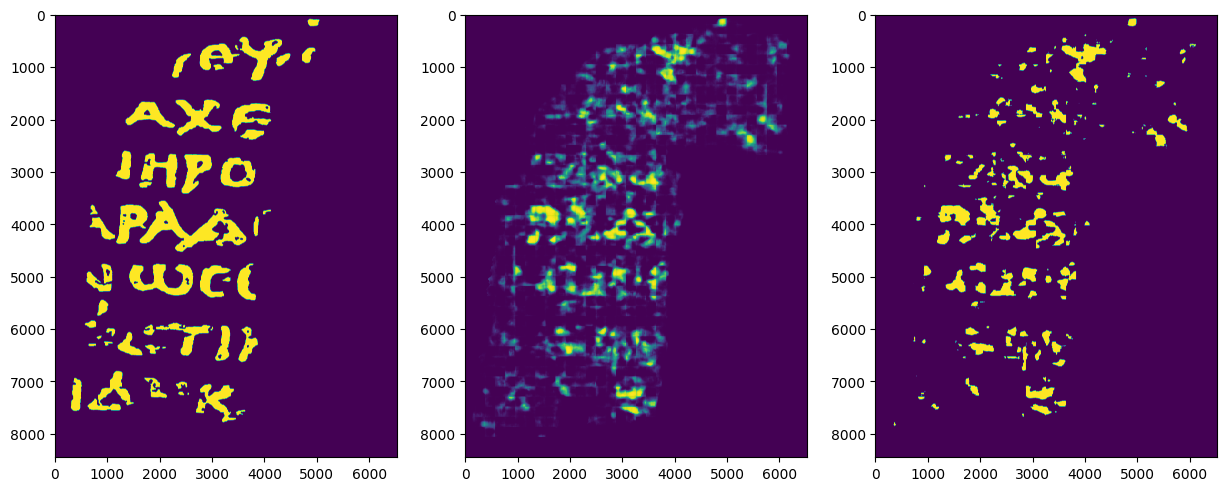

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([44950424.,  2293762.,  1367212.,   993637.,   798443.,   634514.,
          517827.,   455433.,   396542.,   348604.,   299617.,   251927.,
          227734.,   215541.,   204741.,   201612.,   202980.,   203180.,
          233190.,   351624.]),
 array([5.76752285e-10, 4.99736702e-02, 9.99473398e-02, 1.49921009e-01,
        1.99894679e-01, 2.49868349e-01, 2.99842018e-01, 3.49815688e-01,
        3.99789358e-01, 4.49763027e-01, 4.99736697e-01, 5.49710366e-01,
        5.99684036e-01, 6.49657706e-01, 6.99631375e-01, 7.49605045e-01,
        7.99578714e-01, 8.49552384e-01, 8.99526054e-01, 9.49499723e-01,
        9.99473393e-01]),
 <BarContainer object of 20 artists>)

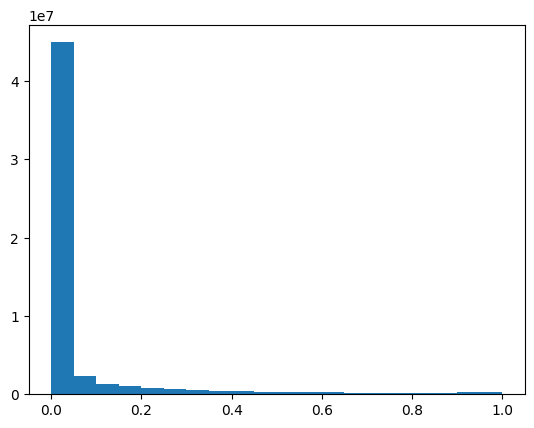

In [34]:
plt.hist(mask_pred.flatten(), bins=20)